<u>**Preamble**</u>: This is a data analysis and modeling project to predict voter party preference in Estonia on the basis of demographics. The intended process involves initial data exploration, followed by the construction, fitting, and analysis of a series of increasingly complex Bayesian categorical models. This Bayesian approach offers a robust alternative to traditional frequentist Analysis of Variance (ANOVA) methods commonly employed in scientific research and A/B/n testing in fields such as marketing, user experience (UX), and web design. A significant benefit of the Bayesian model is its inherent ability to quantify predictive uncertainty through the calculation of posterior (inferential) probability distributions, contrasting with the reliance on sampling distributions in frequentist procedures

<u>**Contents**</u>:

1. Exploratory Data Analysis
2. Modeling
    <br> $→$ Model Building and, Prior Elicitation and Prior Predictive Checks
    <br> $→$ Model Fitting and Goodness-of-Fit Analysis
    <br> $→$ Posterior Predictive Checks
    <br> $→$ Summary and Conclusion

 <u>**Data Provenance**</u>: This data is courtesy of [SALK](https://salk.ee/). SALK refers to the Liberal Citizen Foundation in Estonia; a political organization aimed at influencing Estonian policy and parliamentary elections. This foundation was established with the (ultimately attained) goal of helping liberal forces gain a majority in the 2023 Estonian parliamentary elections.

<u>**Acknowledgments**</u>: I thank [Alex Andorra](https://topmate.io/alex_andorra) and the folks at [Intuitive Bayes](https://www.intuitivebayes.com/) for helping me understand non-identifiability and overparameterization in statistical modeling.

In [1]:
import arviz as az
import matplotlib.pyplot as pp
from matplotlib import rcParams
import numpy as np
import pandas as pd

import pymc as pm

In [2]:
rcParams['font.size'] = 12

#### 1. Exploratory Data Analysis

In [3]:
data = pd.read_csv('./data/estonian-data.csv')

In [4]:
data.head().T

0  \
age_group                                            16-24   
education                                  Basic education   
gender                                                Male   
nationality                                       Estonian   
electoral_district   Haabersti, Põhja-Tallinn ja Kristiine   
unit                                             Kristiine   
EKRE                                                     0   
Eesti 200                                                0   
Hard to say                                              0   
Isamaa                                                   0   
Keskerakond                                              0   
Mitte ükski erakond                                      1   
Other                                                    0   
Parempoolsed                                             0   
Reformierakond                                           0   
Rohelised                                                0   
SDE                                                      0   

                                      1                   2  \
age_group                         16-24               16-24   
education               Basic education     Basic education   
gender                             Male                Male   
nationality                    Estonian            Estonian   
electoral_district   Harju- ja Raplamaa  Harju- ja Raplamaa   
unit                           Harjumaa            Harjumaa   
EKRE                                  0                   0   
Eesti 200                             0                   0   
Hard to say                           0                   0   
Isamaa                                0                   0   
Keskerakond                           0                   0   
Mitte ükski erakond                   0                   0   
Other                                 0                   0   
Parempoolsed                          0                   0   
Reformierakond                        1                   0   
Rohelised                             0                   0   
SDE                                   0                   1   

                                      3                   4  
age_group                         16-24               16-24  
education               Basic education     Basic education  
gender                             Male                Male  
nationality                    Estonian            Estonian  
electoral_district   Harju- ja Raplamaa  Harju- ja Raplamaa  
unit                           Harjumaa            Harjumaa  
EKRE                                  1                   0  
Eesti 200                             0                   0  
Hard to say                           0                   0  
Isamaa                                0                   0  
Keskerakond                           0                   1  
Mitte ükski erakond                   0                   0  
Other                                 0                   0  
Parempoolsed                          0                   0  
Reformierakond                        0                   0  
Rohelised                             0                   0  
SDE                                   0                   0

I don't like the "Hard to say" column name; replace below with the clearer "Undecided" label.

In [5]:
data.rename(columns={'Hard to say': 'Undecided'}, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5206 entries, 0 to 5205
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_group            5206 non-null   object
 1   education            5206 non-null   object
 2   gender               5206 non-null   object
 3   nationality          5206 non-null   object
 4   electoral_district   5206 non-null   object
 5   unit                 5206 non-null   object
 6   EKRE                 5206 non-null   int64 
 7   Eesti 200            5206 non-null   int64 
 8   Undecided            5206 non-null   int64 
 9   Isamaa               5206 non-null   int64 
 10  Keskerakond          5206 non-null   int64 
 11  Mitte ükski erakond  5206 non-null   int64 
 12  Other                5206 non-null   int64 
 13  Parempoolsed         5206 non-null   int64 
 14  Reformierakond       5206 non-null   int64 
 15  Rohelised            5206 non-null   int64 
 16  SDE   

In [7]:
data.columns.tolist()

['age_group',
 'education',
 'gender',
 'nationality',
 'electoral_district',
 'unit',
 'EKRE',
 'Eesti 200',
 'Undecided',
 'Isamaa',
 'Keskerakond',
 'Mitte ükski erakond',
 'Other',
 'Parempoolsed',
 'Reformierakond',
 'Rohelised',
 'SDE']

In [8]:
data.describe().T

count      mean       std  min  25%  50%  75%  max
EKRE                 5206.0  0.124856  0.330587  0.0  0.0  0.0  0.0  1.0
Eesti 200            5206.0  0.082981  0.275880  0.0  0.0  0.0  0.0  1.0
Undecided            5206.0  0.127353  0.333400  0.0  0.0  0.0  0.0  1.0
Isamaa               5206.0  0.054552  0.227126  0.0  0.0  0.0  0.0  1.0
Keskerakond          5206.0  0.119285  0.324155  0.0  0.0  0.0  0.0  1.0
Mitte ükski erakond  5206.0  0.181521  0.385487  0.0  0.0  0.0  0.0  1.0
Other                5206.0  0.007876  0.088403  0.0  0.0  0.0  0.0  1.0
Parempoolsed         5206.0  0.002305  0.047960  0.0  0.0  0.0  0.0  1.0
Reformierakond       5206.0  0.215136  0.410956  0.0  0.0  0.0  0.0  1.0
Rohelised            5206.0  0.017480  0.131063  0.0  0.0  0.0  0.0  1.0
SDE                  5206.0  0.066654  0.249446  0.0  0.0  0.0  0.0  1.0

In [9]:
data.loc[:, 'EKRE':].sum(axis=1).describe().loc[['min', 'max']]

min    1.0
max    1.0
dtype: float64

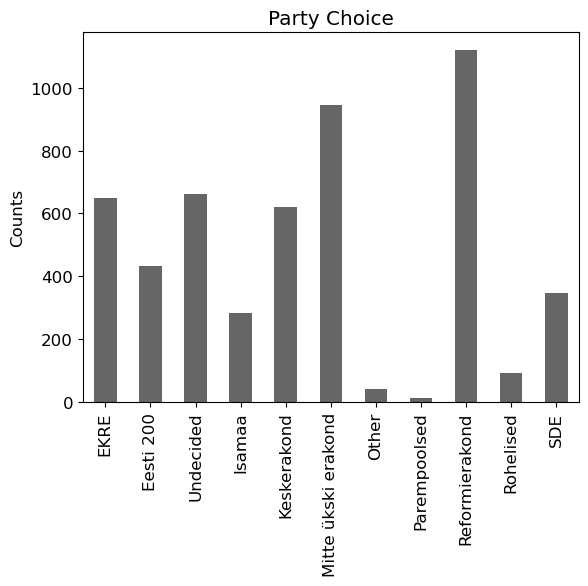

In [10]:
data.loc[:, 'EKRE':].sum(axis=0).plot(kind='bar', title='Party Choice', ylabel='Counts', color='black', alpha=0.6);

In [11]:
data.electoral_district.unique().size, data.unit.unique().size

(12, 24)

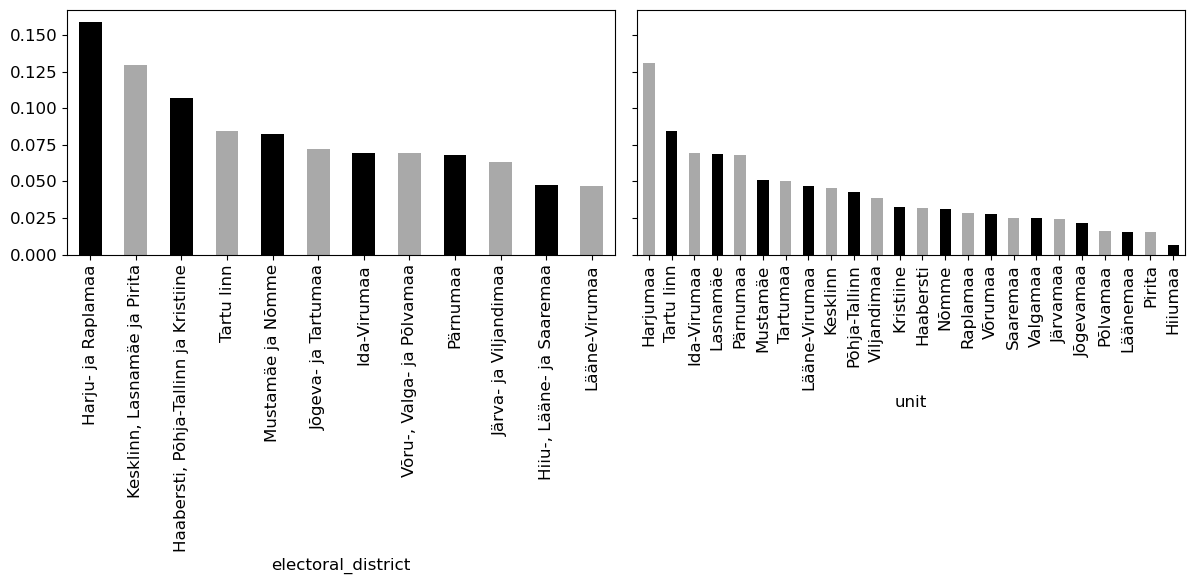

In [12]:
f, (left, right) = pp.subplots(ncols=2, figsize=(12, 6), sharey=True)
data.electoral_district.value_counts(normalize=True).plot(kind='bar', color=['black', 'darkgray'], ax=left)
data.unit.value_counts(normalize=True).plot(kind='bar', color=['darkgray', 'black'])
left.set_xticklabels(left.get_xticklabels(), rotation=90)
f.tight_layout();

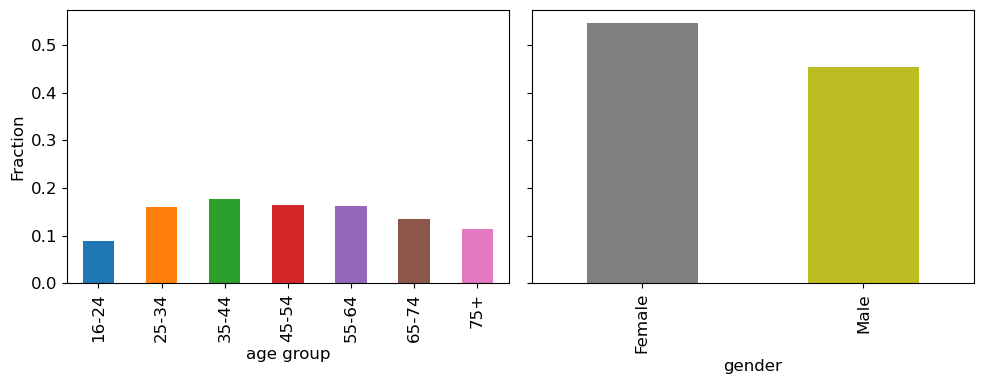

In [13]:
f, (left, right) = pp.subplots(ncols=2, figsize=(10, 4), sharey=True)
data.age_group.value_counts(normalize=True, sort=False).plot(kind='bar', color=[f'C{i}' for i in range(7)], ax=left);
data.gender.value_counts(normalize=True).plot(kind='bar', color= ['C7', 'C8'], ax=right)
left.set(ylabel='Fraction', xlabel='age group')
f.tight_layout()


In [14]:
data.education.value_counts()

education
Secondary education    2684
Higher education       1948
Basic education         574
Name: count, dtype: int64

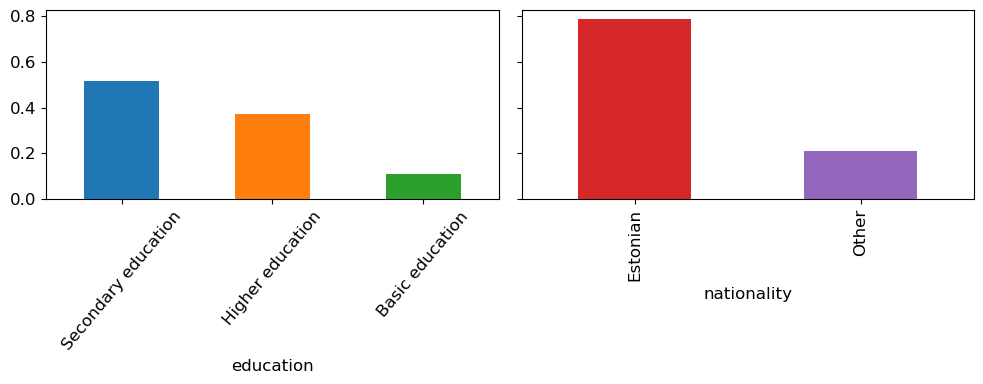

In [15]:
f, (left, right) = pp.subplots(ncols=2, figsize=(10, 4), sharey=True)
data.education.value_counts(normalize=True).plot(kind='bar', color=[f'C{i}' for i in range(0, 3)], ax=left)
data.nationality.value_counts(normalize=True).plot(kind='bar', color=['C3', 'C4'])
left.set_xticklabels(left.get_xticklabels(), rotation=50)
f.tight_layout();

##### Preliminary summary:

This table registers voter preference. Each row is a voter. Columns include voter demographics, the election district and unit. The rest of the columns are each dedicated to a party.  Data are in the thousands with no apparent missing value.
There are two types of data; (1) strings that lend themselves to categorization, and (2) binary data indicating whether a given party has received the vote of that row's  voter. There were no irregularities, i.e. more than 1 vote registered for each person;  there were no abstentions noted in this dataset either. 
All the data is categorical with the following number of categories:
* Party choice $→$ 11
* Electoral district $\rightarrow$ 12
* (Electoral) Unit $→$ 24
* AGe group $→$ 7
* Gender $→$ 2
* Education $→$ 3
* Nationality $→$ 2



##### Preliminary summary, part 2: 
There is some imbalance in education level, with secondary education being the more proeminent. There is notable imbalance in nationality, with predictable majority of Estonian representation. Party choice, electoral district and unit are also quite imbalanced. Next is to examine party representation breakdown at the  group level. Note that I will not consider electoral district and unit hereafter as the emphasis is on demographics as a driver of party choice.

In [16]:
def make_group_percentage(df: pd.DataFrame, category: 'str') -> pd.DataFrame:
    """Computes percentage for each column in a group"""
    group = df.groupby(category).sum(numeric_only=True)
    group_percent = group.div(group.sum(axis=1), axis=0)*100
    return group_percent


In [17]:
party_names = data.loc[:, 'EKRE':].columns.tolist()
party_names

['EKRE',
 'Eesti 200',
 'Undecided',
 'Isamaa',
 'Keskerakond',
 'Mitte ükski erakond',
 'Other',
 'Parempoolsed',
 'Reformierakond',
 'Rohelised',
 'SDE']

In [18]:
data.head()

age_group        education gender nationality  \
0     16-24  Basic education   Male    Estonian   
1     16-24  Basic education   Male    Estonian   
2     16-24  Basic education   Male    Estonian   
3     16-24  Basic education   Male    Estonian   
4     16-24  Basic education   Male    Estonian   

                      electoral_district       unit  EKRE  Eesti 200  \
0  Haabersti, Põhja-Tallinn ja Kristiine  Kristiine     0          0   
1                     Harju- ja Raplamaa   Harjumaa     0          0   
2                     Harju- ja Raplamaa   Harjumaa     0          0   
3                     Harju- ja Raplamaa   Harjumaa     1          0   
4                     Harju- ja Raplamaa   Harjumaa     0          0   

   Undecided  Isamaa  Keskerakond  Mitte ükski erakond  Other  Parempoolsed  \
0          0       0            0                    1      0             0   
1          0       0            0                    0      0             0   
2          0       0            0                    0      0             0   
3          0       0            0                    0      0             0   
4          0       0            1                    0      0             0   

   Reformierakond  Rohelised  SDE  
0               0          0    0  
1               1          0    0  
2               0          0    1  
3               0          0    0  
4               0          0    0

In [19]:
data.groupby('gender').sum(
numeric_only=True
)

EKRE  Eesti 200  Undecided  Isamaa  Keskerakond  Mitte ükski erakond  \
gender                                                                         
Female   271        237        412     119          374                  507   
Male     379        195        251     165          247                  438   

        Other  Parempoolsed  Reformierakond  Rohelised  SDE  
gender                                                       
Female     18             7             620         55  225  
Male       23             5             500         36  122

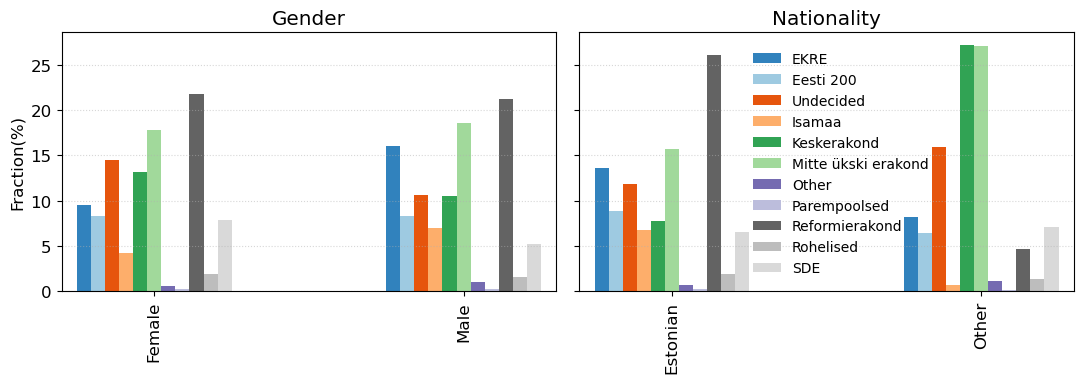

In [20]:
f, (left, right) = pp.subplots(ncols=2, figsize=(11, 4), sharey=True)
#gender = data.groupby('gender').sum(numeric_only=True)
#(gender.div(gender.sum(axis=1), axis=0)*100).plot(kind='bar', colormap='tab20c', ax=left, legend=False)
#data.groupby('nationality').sum(numeric_only=True).plot(kind='bar', colormap='tab20c', ax=right, legend=False)
make_group_percentage(data, 'gender').plot(kind='bar', colormap='tab20c', ax=left, legend=False)
make_group_percentage(data, 'nationality').plot(kind='bar', colormap='tab20c', ax=right)
left.set(title='Gender', ylabel='Fraction(%)', xlim=(-0.3, 1.3), xlabel='')
right.set(xlim=(-0.3, 1.3), title='Nationality', xlabel='')
right.legend(frameon=False, loc=(0.34 ,0.04), fontsize=10)
right.grid(axis='y', alpha=0.5, ls=':')
left.grid(axis='y', alpha=0.5, ls=':')
f.tight_layout();

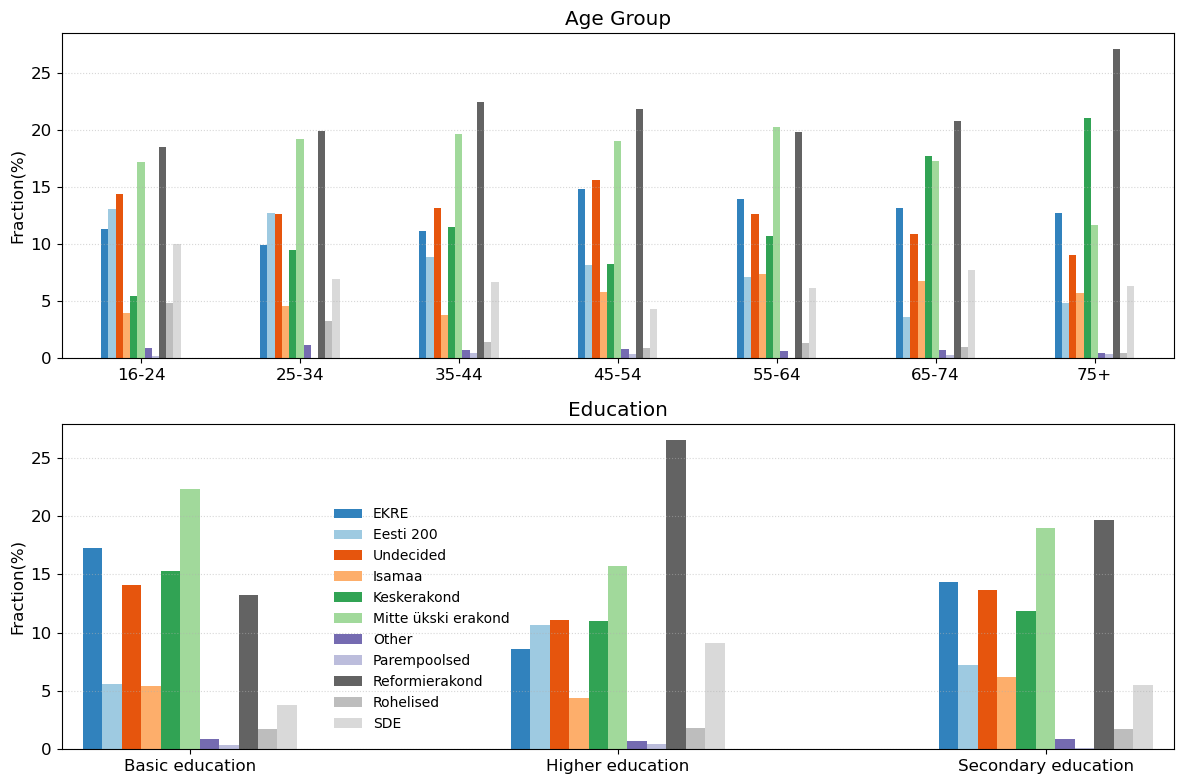

In [21]:
f, (top, bottom) = pp.subplots(nrows=2, figsize=(12, 8))
#data.groupby('age_group').sum(numeric_only=True)
make_group_percentage(data, 'age_group').plot(kind='bar', colormap='tab20c', ax=top, legend=False)
#data.groupby('education').sum(numeric_only=True)
make_group_percentage(data, 'education').plot(kind='bar', colormap='tab20c', ax=bottom, legend=False, )
top.set(title='Age Group', ylabel='Fraction(%)', xlabel='')
top.set_xticklabels(top.get_xticklabels(), rotation=0)
bottom.legend(frameon=False,  loc=(0.24, 0.04), fontsize=10)
bottom.set_xticklabels(bottom.get_xticklabels(), rotation=0)
bottom.set(ylabel='Fraction(%)', title='Education', xlim=(-0.3, 2.3), xlabel='')
bottom.grid(axis='y', alpha=0.5, ls=':')
top.grid(axis='y', alpha=0.5, ls=':')
f.tight_layout();

#### Grouped data summary
1. Overall
    * Reformierakond (a liberal party) is pretty popular across the board except with non-Estonians; 
    * Non-Estonians - I'm told - is almost entirely composed up of Russians;
    * There is a fair amount of undecided voters;
    * EKRE and Keskeradon are populist parties - EKRE is right-wing, Keskerakond is center-left;
    * Parempoolsed, center-right party is the underdog across the board.

2. Group-specific
    * *Gender*: there are some subtle  differences. 
        * Reformierakond is slightly more popular with female voters;
        * There are more undecided among female voters;
        * The right-wing EKRE is more popular with male voters.
    * *Nationality*:
        * Reformierakond, EKRE are more popular with Estonians;
        * Keskerakond, Mitte ukski erakond are favored by ethnic Russians who are also more numerous to be undecided. 
    * *Age group*:
        * Mitte ukski erakond and Reformierakond are the two prevaiing parties among each age group except the two older tranches;
        * Among 65 and over Reformierakond retains the top but Mitte recedes in favor of Keskeradond.
    * *Education*:
        * EKRE, Undecided, Mitte ukski erakond are the top 3 party choices for those with a basic education;
        * Reformierakond and Mitte are the top 2 party choices among those with a college degree.
        * High school graduates exhibit a preference for Reformierakond, Mitte, and EKRE.

#### 2. Modeling

The goal is to predict party preference on the basis of available demographic data. 
I will first start with looking at two categories; education and nationality. The below is some data encoding to ease model fitting and clarity of plotted results. In particular note the model coordinate names; 'party_choice', 'education', 'nationality', 'obs_idx'. The latter is just the row index of the dataframe containing the observations; each row corresponding to one observation.

In [22]:
# response variable encoding
party_choice = pd.Categorical(data[party_names].idxmax(axis=1), categories=party_names, ordered=True)
party_choice_label = party_choice.categories.to_list()
party_choice_code = party_choice.codes

# input variables encoding
education_code, education_label = data.education.factorize(sort=True) 
nationality_code, nationality_label = data.nationality.factorize(sort=True)

# setting model coordinates

coords = {
    'party_choice': party_choice_label,
    'education': education_label,
    'nationality': nationality_label,
    'obs_idx': data.index} # observation index, the row location of an observation in the dataframe.

Below I write a first model using a baseline intercept and I use nationality and education as predictors and baseline offsets. The corresponding coefficients have 'party choice' as dimension (11 possibilities) and in the case of education and nationality, have  also a dimension of 'education' (3 possibilities) and 'nationality' (2 possibilities), respectively. These are linearly combined and passed to a softmax function to scale the output to the $(0-1)$ interval, as shown below.
$$ p = softmax(α_{baseline} + α_{nationality}[\small{nationality\_category}] + α_{education}[\small{education\_category}]) $$

As prior distribution for all three coefficients, instead of using the $\mathcal{Normal}$ distribution, I use below the $\mathcal{Zero-sum\ Normal}$. This distribution imposes zero sum constraints on specified axes of the fitted coefficients, thereby addressing the problem of overparameterization and identifiability that often plague categorical regression models; a subject of my blog post found [here](insert link). 

Finally I use for likelihood the $\mathcal{Categorical}$ distribution, which is a n-dimensional $\mathcal{Bernoulli}$ process, and through which I expose the model to the data.

In [23]:
def build_model1(α_sigma=1, α_nat_sigma=1, α_edu_sigma=1):
    with pm.Model(coords=coords) as model1:
        # Data containers
        party_choice_idx = pm.Data('party_choice_index', party_choice_code, dims='obs_idx')
        nationality_idx = pm.Data('nationality_index', nationality_code, dims='obs_idx')
        education_idx = pm.Data('eductation_index', education_code, dims='obs_idx')
        
        # Model priors
        # baseline
        α = pm.ZeroSumNormal('α', sigma=α_sigma, dims='party_choice') 
        # baseline offset due to nationality
        α_nationality = pm.ZeroSumNormal('α_nationality', sigma=α_nat_sigma, dims=('nationality', 'party_choice'), n_zerosum_axes=2) 
        # baseline offset due to education
        α_education = pm.ZeroSumNormal('α_education', sigma=α_edu_sigma, dims=('education', 'party_choice'), n_zerosum_axes=2)

        # Link function for choice probability
        p = pm.math.softmax(α + α_nationality[nationality_idx] + α_education[education_idx], axis=-1)
        
        # Likelihood
        _ = pm.Categorical('y', p=p, observed=party_choice_idx, dims='obs_idx')
    return model1


In [24]:
model1 = build_model1()

Below is the model's diagram with dimension information included. 

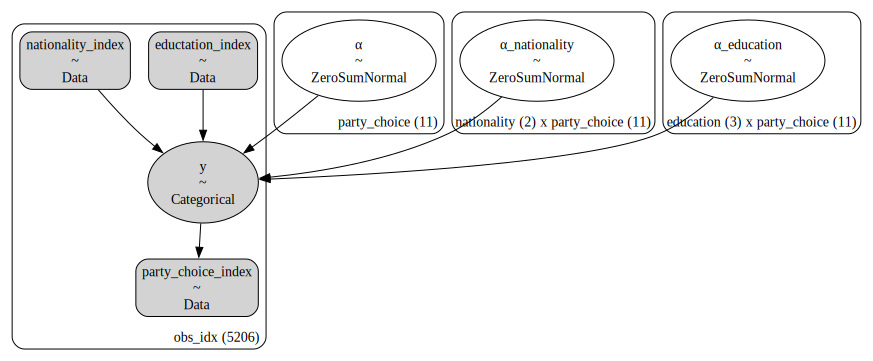

In [25]:
model1.to_graphviz()

Next is to sample model priors to see the soundness of assumptions made

In [26]:
with model1:
    idata1 = pm.sample_prior_predictive(model=model1)
    idata1.extend(pm.sample(chains=4, draws=2000, random_seed=42))
    idata1.extend(pm.sample_posterior_predictive(idata1))

Sampling: [y, α, α_education, α_nationality]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, α_nationality, α_education]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 96 seconds.
Sampling: [y]


Output()

In [27]:
def plot_forward_samples(
        idata: az.InferenceData, categories:list, categories_name:str, 
        figsize=(12, 6), plot_prior=True, plot_posterior=True):
    """A quick function to plot model predictives. """
    f, (left, right) = pp.subplots(1, 2, figsize=figsize, sharey=True)
    xticks = [i + 0.5 for i in range(len(categories))]
    if plot_prior:
        az.plot_ppc(idata, group="prior", ax=left)
        left.set(
            xticks=xticks,
        )
        left.set_xticklabels(categories, fontsize=10, rotation=30)
        left.set_xlabel(categories_name, fontsize=16)
        left.legend(frameon=True, fontsize=11)
    else:
        left.set_visible(False)

    if plot_posterior:
        az.plot_ppc(idata, ax=right)
        right.set(
            xticks=xticks,
        )
        right.set_xticklabels(categories, fontsize=10, rotation=30)
        right.set_xlabel(categories_name, fontsize=16)
        right.legend(frameon=True, fontsize=11)
    else:
        right.set_visible(False)
    f.tight_layout()
    return f, (left, right)

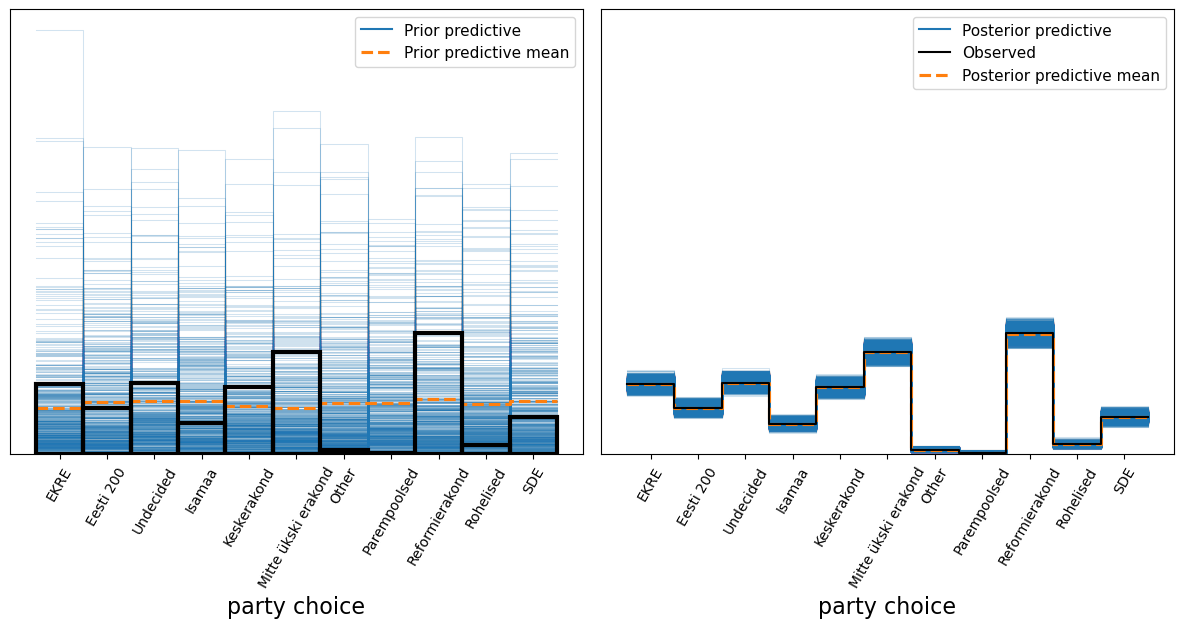

In [28]:
mean_win = pd.Series(party_choice_code).value_counts(normalize=True).round(3).sort_index()
f, (axl, axr) = plot_forward_samples(idata1, categories=party_choice_label, categories_name='party choice', figsize=(12, 6))
axl.set_xticklabels(axl.get_xticklabels(), rotation=60);
axl.bar(x=axl.get_xticks(), height=mean_win.values,  color='k', fill=False, lw=3, width=1, zorder=13, label='data');
axr.set_xticklabels(axr.get_xticklabels(), rotation=60);

Left, in blue lines are sample outcomes for each party choice, before the model has seen the data. Right, model fit results (posterior distribution for each category). The model seems to have learned the posterior distribution well. The model did take some time to fit though and in spite of the lack of difergences, one wonders if sampling could be more efficient. Domain experts have suggested a tighter variance on the coefficient priors could indeed ease sampling. Model1b integrates this domain knowledge as follows: 

In [29]:
model1b = build_model1(α_sigma=0.5, α_edu_sigma=0.2, α_nat_sigma=0.3)

In [30]:
with model1b:
    idata1b = pm.sample_prior_predictive()
    idata1b.extend(pm.sample(chains=4, draws=2000, random_seed=42))
    idata1b.extend(pm.sample_posterior_predictive(idata1b))

Sampling: [y, α, α_education, α_nationality]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, α_nationality, α_education]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 88 seconds.
Sampling: [y]


Output()

There was some speed improvement (~ 18 seconds on a Macbook air M2.)
#### Assessing goodness of fit

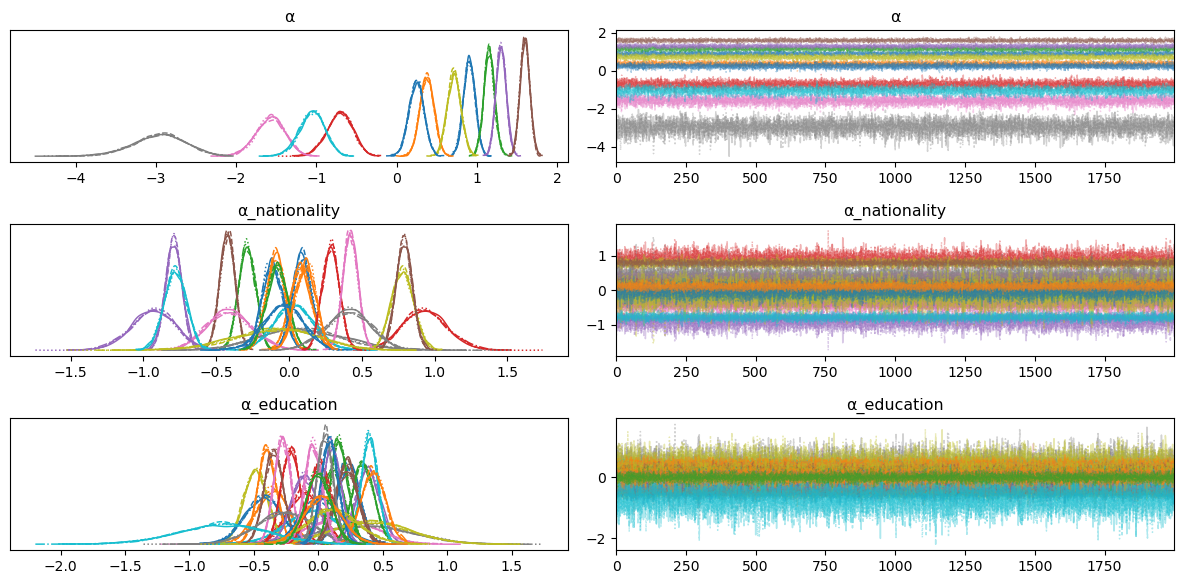

In [31]:
az.plot_trace(idata1, backend_kwargs={'tight_layout': True});

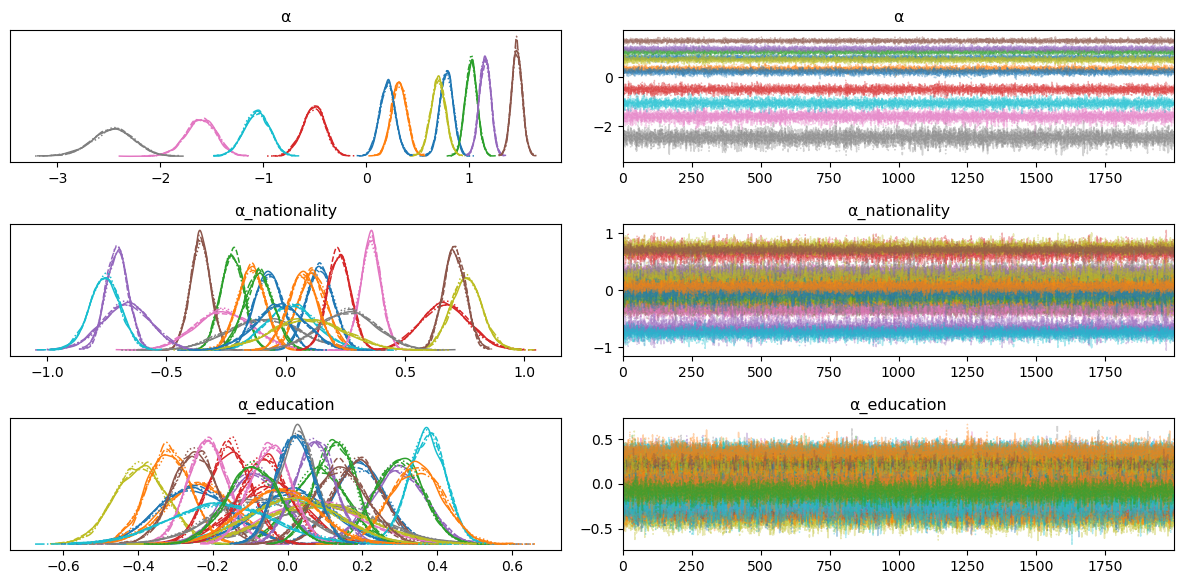

In [32]:
az.plot_trace(idata1b, backend_kwargs=dict(tight_layout=True));

Good mixing in the chains and lack of divergences suggest a good fit. The second model (bottom panel) has tighter posteriors, suggesting a slightly better fit.

In [33]:
az.summary(idata1, var_names='α')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
α[EKRE]                 0.906  0.072   0.772    1.042      0.001    0.001   
α[Eesti 200]            0.377  0.087   0.222    0.549      0.001    0.001   
α[Undecided]            1.153  0.067   1.021    1.277      0.001    0.001   
α[Isamaa]              -0.710  0.160  -1.000   -0.405      0.002    0.001   
α[Keskerakond]          1.302  0.063   1.178    1.415      0.001    0.001   
α[Mitte ükski erakond]  1.599  0.059   1.486    1.709      0.001    0.001   
α[Other]               -1.575  0.180  -1.900   -1.225      0.002    0.001   
α[Parempoolsed]        -2.961  0.326  -3.584   -2.365      0.004    0.003   
α[Reformierakond]       0.716  0.084   0.552    0.865      0.001    0.001   
α[Rohelised]           -1.054  0.156  -1.340   -0.752      0.002    0.001   
α[SDE]                  0.246  0.093   0.072    0.419      0.001    0.001   

                        ess_bulk  ess_tail  r_hat  
α[EKRE]                   6612.0    6756.0    1.0  
α[Eesti 200]              6715.0    6112.0    1.0  
α[Undecided]              6441.0    6223.0    1.0  
α[Isamaa]                 8356.0    6113.0    1.0  
α[Keskerakond]            6106.0    6320.0    1.0  
α[Mitte ükski erakond]    5842.0    5910.0    1.0  
α[Other]                 10091.0    6406.0    1.0  
α[Parempoolsed]           5747.0    6096.0    1.0  
α[Reformierakond]         8024.0    6563.0    1.0  
α[Rohelised]              8262.0    6252.0    1.0  
α[SDE]                   11979.0    6935.0    1.0

In [34]:
az.summary(idata1b, var_names='α')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
α[EKRE]                 0.781  0.064   0.660    0.899      0.001    0.000   
α[Eesti 200]            0.320  0.073   0.176    0.452      0.001    0.001   
α[Undecided]            1.020  0.058   0.907    1.126      0.001    0.000   
α[Isamaa]              -0.509  0.109  -0.723   -0.310      0.001    0.001   
α[Keskerakond]          1.155  0.055   1.049    1.253      0.001    0.000   
α[Mitte ükski erakond]  1.464  0.051   1.370    1.563      0.001    0.000   
α[Other]               -1.609  0.147  -1.889   -1.333      0.001    0.001   
α[Parempoolsed]        -2.461  0.202  -2.849   -2.089      0.002    0.001   
α[Reformierakond]       0.698  0.071   0.563    0.830      0.001    0.000   
α[Rohelised]           -1.065  0.121  -1.295   -0.843      0.001    0.001   
α[SDE]                  0.205  0.075   0.073    0.357      0.001    0.001   

                        ess_bulk  ess_tail  r_hat  
α[EKRE]                  12336.0    6688.0    1.0  
α[Eesti 200]             10479.0    6316.0    1.0  
α[Undecided]             10735.0    6572.0    1.0  
α[Isamaa]                10705.0    5825.0    1.0  
α[Keskerakond]           10455.0    6907.0    1.0  
α[Mitte ükski erakond]    9276.0    6427.0    1.0  
α[Other]                 12469.0    6006.0    1.0  
α[Parempoolsed]          10961.0    5924.0    1.0  
α[Reformierakond]        10962.0    6083.0    1.0  
α[Rohelised]             10573.0    6503.0    1.0  
α[SDE]                   11252.0    6818.0    1.0

Looking at the model fit summary tables for the baseline $α$ parameter, in both cases the $\hat{R}$ (aka *Gelman-Rubin* statistic) is 1.0. This indicates good convergence of MCMC chains (I fired up 4 of them for sampling). Interestingly however, in the case of the second model with tighter variance constraints on the priors, the *Effective Sample Size* corresponding to the sampling of the central portion of the posterior (ess_bulk) shows more efficient sampling in most cases. The posterior is therefore likelier to be better characterized. A similar pattern can be observed in the next 4 tables for $α_{nationality}$ and $α_{education}$. Note that in contrast, the tails of the posterior are sampled with similar efficiency in both cases, as noted by ess_tail. 

In [35]:
az.summary(idata1, var_names='α_education')

mean     sd  hdi_3%  \
α_education[Basic education, EKRE]                  0.234  0.088   0.072   
α_education[Basic education, Eesti 200]            -0.359  0.125  -0.602   
α_education[Basic education, Undecided]             0.110  0.091  -0.052   
α_education[Basic education, Isamaa]               -0.110  0.129  -0.352   
α_education[Basic education, Keskerakond]           0.385  0.091   0.212   
α_education[Basic education, Mitte ükski erakond]   0.226  0.082   0.067   
α_education[Basic education, Other]                 0.148  0.276  -0.357   
α_education[Basic education, Parempoolsed]          0.332  0.382  -0.402   
α_education[Basic education, Reformierakond]       -0.486  0.092  -0.658   
α_education[Basic education, Rohelised]            -0.054  0.205  -0.446   
α_education[Basic education, SDE]                  -0.426  0.144  -0.696   
α_education[Higher education, EKRE]                -0.399  0.072  -0.530   
α_education[Higher education, Eesti 200]            0.348  0.084   0.200   
α_education[Higher education, Undecided]           -0.216  0.071  -0.343   
α_education[Higher education, Isamaa]              -0.110  0.098  -0.292   
α_education[Higher education, Keskerakond]         -0.347  0.072  -0.481   
α_education[Higher education, Mitte ükski erakond] -0.278  0.064  -0.395   
α_education[Higher education, Other]               -0.259  0.219  -0.655   
α_education[Higher education, Parempoolsed]         0.414  0.304  -0.160   
α_education[Higher education, Reformierakond]       0.397  0.064   0.279   
α_education[Higher education, Rohelised]            0.021  0.152  -0.253   
α_education[Higher education, SDE]                  0.428  0.094   0.258   
α_education[Secondary education, EKRE]              0.164  0.067   0.039   
α_education[Secondary education, Eesti 200]         0.011  0.085  -0.150   
α_education[Secondary education, Undecided]         0.106  0.069  -0.025   
α_education[Secondary education, Isamaa]            0.220  0.092   0.041   
α_education[Secondary education, Keskerakond]      -0.038  0.070  -0.167   
α_education[Secondary education, Mitte ükski er...  0.052  0.062  -0.063   
α_education[Secondary education, Other]             0.111  0.201  -0.277   
α_education[Secondary education, Parempoolsed]     -0.745  0.350  -1.389   
α_education[Secondary education, Reformierakond]    0.088  0.065  -0.038   
α_education[Secondary education, Rohelised]         0.033  0.144  -0.235   
α_education[Secondary education, SDE]              -0.002  0.097  -0.187   

                                                    hdi_97%  mcse_mean  \
α_education[Basic education, EKRE]                    0.400      0.001   
α_education[Basic education, Eesti 200]              -0.134      0.001   
α_education[Basic education, Undecided]               0.290      0.001   
α_education[Basic education, Isamaa]                  0.129      0.001   
α_education[Basic education, Keskerakond]             0.555      0.001   
α_education[Basic education, Mitte ükski erakond]     0.376      0.001   
α_education[Basic education, Other]                   0.665      0.003   
α_education[Basic education, Parempoolsed]            1.037      0.004   
α_education[Basic education, Reformierakond]         -0.317      0.001   
α_education[Basic education, Rohelised]               0.317      0.002   
α_education[Basic education, SDE]                    -0.155      0.001   
α_education[Higher education, EKRE]                  -0.259      0.001   
α_education[Higher education, Eesti 200]              0.515      0.001   
α_education[Higher education, Undecided]             -0.075      0.001   
α_education[Higher education, Isamaa]                 0.076      0.001   
α_education[Higher education, Keskerakond]           -0.212      0.001   
α_education[Higher education, Mitte ükski erakond]   -0.158      0.001   
α_education[Higher education, Other]                  0.164      0.002   
α_education[Higher education, Parempoolsed]           0.981   

In [36]:
az.summary(idata1b, var_names='α_education')

mean     sd  hdi_3%  \
α_education[Basic education, EKRE]                  0.191  0.070   0.055   
α_education[Basic education, Eesti 200]            -0.235  0.090  -0.400   
α_education[Basic education, Undecided]             0.083  0.073  -0.060   
α_education[Basic education, Isamaa]               -0.050  0.093  -0.231   
α_education[Basic education, Keskerakond]           0.295  0.074   0.156   
α_education[Basic education, Mitte ükski erakond]   0.189  0.066   0.060   
α_education[Basic education, Other]                 0.065  0.135  -0.184   
α_education[Basic education, Parempoolsed]          0.097  0.144  -0.174   
α_education[Basic education, Reformierakond]       -0.393  0.070  -0.517   
α_education[Basic education, Rohelised]             0.009  0.122  -0.223   
α_education[Basic education, SDE]                  -0.251  0.097  -0.426   
α_education[Higher education, EKRE]                -0.318  0.059  -0.430   
α_education[Higher education, Eesti 200]            0.297  0.065   0.177   
α_education[Higher education, Undecided]           -0.155  0.057  -0.261   
α_education[Higher education, Isamaa]              -0.091  0.076  -0.235   
α_education[Higher education, Keskerakond]         -0.249  0.060  -0.367   
α_education[Higher education, Mitte ükski erakond] -0.214  0.053  -0.316   
α_education[Higher education, Other]               -0.080  0.121  -0.308   
α_education[Higher education, Parempoolsed]         0.080  0.137  -0.178   
α_education[Higher education, Reformierakond]       0.373  0.050   0.276   
α_education[Higher education, Rohelised]            0.014  0.105  -0.181   
α_education[Higher education, SDE]                  0.344  0.071   0.214   
α_education[Secondary education, EKRE]              0.127  0.053   0.031   
α_education[Secondary education, Eesti 200]        -0.062  0.065  -0.185   
α_education[Secondary education, Undecided]         0.072  0.054  -0.027   
α_education[Secondary education, Isamaa]            0.140  0.072   0.007   
α_education[Secondary education, Keskerakond]      -0.046  0.055  -0.144   
α_education[Secondary education, Mitte ükski er...  0.025  0.049  -0.068   
α_education[Secondary education, Other]             0.015  0.119  -0.205   
α_education[Secondary education, Parempoolsed]     -0.177  0.136  -0.437   
α_education[Secondary education, Reformierakond]    0.020  0.050  -0.073   
α_education[Secondary education, Rohelised]        -0.023  0.100  -0.209   
α_education[Secondary education, SDE]              -0.092  0.070  -0.223   

                                                    hdi_97%  mcse_mean  \
α_education[Basic education, EKRE]                    0.320      0.001   
α_education[Basic education, Eesti 200]              -0.062      0.001   
α_education[Basic education, Undecided]               0.214      0.001   
α_education[Basic education, Isamaa]                  0.118      0.001   
α_education[Basic education, Keskerakond]             0.434      0.001   
α_education[Basic education, Mitte ükski erakond]     0.309      0.001   
α_education[Basic education, Other]                   0.323      0.001   
α_education[Basic education, Parempoolsed]            0.365      0.001   
α_education[Basic education, Reformierakond]         -0.256      0.001   
α_education[Basic education, Rohelised]               0.228      0.001   
α_education[Basic education, SDE]                    -0.063      0.001   
α_education[Higher education, EKRE]                  -0.208      0.000   
α_education[Higher education, Eesti 200]              0.419      0.001   
α_education[Higher education, Undecided]             -0.047      0.001   
α_education[Higher education, Isamaa]                 0.051      0.001   
α_education[Higher education, Keskerakond]           -0.139      0.001   
α_education[Higher education, Mitte ükski erakond]   -0.116      0.000   
α_education[Higher education, Other]                  0.149      0.001   
α_education[Higher education, Parempoolsed]           0.335   

In [37]:
az.summary(idata1, var_names='α_nationality')

mean     sd  hdi_3%  hdi_97%  \
α_nationality[Estonian, EKRE]                 0.091  0.064  -0.031    0.210   
α_nationality[Estonian, Eesti 200]            0.081  0.072  -0.059    0.213   
α_nationality[Estonian, Undecided]           -0.287  0.058  -0.394   -0.182   
α_nationality[Estonian, Isamaa]               0.935  0.151   0.660    1.228   
α_nationality[Estonian, Keskerakond]         -0.791  0.056  -0.888   -0.677   
α_nationality[Estonian, Mitte ükski erakond] -0.422  0.052  -0.520   -0.327   
α_nationality[Estonian, Other]               -0.407  0.155  -0.703   -0.120   
α_nationality[Estonian, Parempoolsed]         0.095  0.292  -0.427    0.655   
α_nationality[Estonian, Reformierakond]       0.780  0.076   0.639    0.921   
α_nationality[Estonian, Rohelised]            0.039  0.135  -0.209    0.290   
α_nationality[Estonian, SDE]                 -0.113  0.070  -0.236    0.024   
α_nationality[Other, EKRE]                   -0.091  0.064  -0.210    0.031   
α_nationality[Other, Eesti 200]              -0.081  0.072  -0.213    0.059   
α_nationality[Other, Undecided]               0.287  0.058   0.182    0.394   
α_nationality[Other, Isamaa]                 -0.935  0.151  -1.228   -0.660   
α_nationality[Other, Keskerakond]             0.791  0.056   0.677    0.888   
α_nationality[Other, Mitte ükski erakond]     0.422  0.052   0.327    0.520   
α_nationality[Other, Other]                   0.407  0.155   0.120    0.703   
α_nationality[Other, Parempoolsed]           -0.095  0.292  -0.655    0.427   
α_nationality[Other, Reformierakond]         -0.780  0.076  -0.921   -0.639   
α_nationality[Other, Rohelised]              -0.039  0.135  -0.290    0.209   
α_nationality[Other, SDE]                     0.113  0.070  -0.024    0.236   

                                              mcse_mean  mcse_sd  ess_bulk  \
α_nationality[Estonian, EKRE]                     0.001    0.001    7281.0   
α_nationality[Estonian, Eesti 200]                0.001    0.001    8736.0   
α_nationality[Estonian, Undecided]                0.001    0.001    6742.0   
α_nationality[Estonian, Isamaa]                   0.002    0.001    8963.0   
α_nationality[Estonian, Keskerakond]              0.001    0.000    6695.0   
α_nationality[Estonian, Mitte ükski erakond]      0.001    0.000    6279.0   
α_nationality[Estonian, Other]                    0.001    0.001   12316.0   
α_nationality[Estonian, Parempoolsed]             0.004    0.003    5923.0   
α_nationality[Estonian, Reformierakond]           0.001    0.001    8745.0   
α_nationality[Estonian, Rohelised]                0.001    0.001   10870.0   
α_nationality[Estonian, SDE]                      0.001    0.001   10342.0   
α_nationality[Other, EKRE]                        0.001    0.001    7281.0   
α_nationality[Other, Eesti 200]                   0.001    0.001    8736.0   
α_nationality[Other, Undecided]                   0.001    0.001    6742.0   
α_nationality[Other, Isamaa]                      0.002    0.001    8963.0   
α_nationality[Other, Keskerakond]                 0.001    0.000    6695.0   
α_nationality[Other, Mitte ükski erakond]         0.001    0.000    6279.0   
α_nationality[Other, Other]                       0.001    0.001   12316.0   
α_nationality[Other, Parempoolsed]                0.004    0.003    5923.0   
α_nationality[Other, Reformierakond]              0.001    0.001    8745.0   
α_nationality[Other, Rohelised]                   0.001    0.001   10870.0   
α_nationality[Other, SDE]                         0.001    0.001   10342.0   

                                              ess_tail  r_hat  
α_nationality[Estonian, EKRE]                   6421.0    1.0  
α_nationality[Estonian, Eesti 200]              6470.0    1.0  
α_nationality[Estonian, Undecided]              6367.0    1.0  
α_nationality[Estonian, Isamaa]                 5827.0    1.0  
α_nationality[Estonian, Keskerakond]            6262.0    1.0  
α_nationality[Estonian, Mitte ükski erakond]    61

In [38]:
az.summary(idata1b, var_names='α_nationality')

mean     sd  hdi_3%  hdi_97%  \
α_nationality[Estonian, EKRE]                 0.144  0.057   0.039    0.251   
α_nationality[Estonian, Eesti 200]            0.112  0.062  -0.006    0.229   
α_nationality[Estonian, Undecided]           -0.223  0.049  -0.315   -0.136   
α_nationality[Estonian, Isamaa]               0.669  0.101   0.476    0.854   
α_nationality[Estonian, Keskerakond]         -0.707  0.046  -0.795   -0.621   
α_nationality[Estonian, Mitte ükski erakond] -0.357  0.043  -0.439   -0.277   
α_nationality[Estonian, Other]               -0.260  0.121  -0.489   -0.035   
α_nationality[Estonian, Parempoolsed]        -0.091  0.153  -0.378    0.192   
α_nationality[Estonian, Reformierakond]       0.758  0.065   0.630    0.875   
α_nationality[Estonian, Rohelised]            0.026  0.105  -0.156    0.236   
α_nationality[Estonian, SDE]                 -0.071  0.062  -0.186    0.043   
α_nationality[Other, EKRE]                   -0.144  0.057  -0.251   -0.039   
α_nationality[Other, Eesti 200]              -0.112  0.062  -0.229    0.006   
α_nationality[Other, Undecided]               0.223  0.049   0.136    0.315   
α_nationality[Other, Isamaa]                 -0.669  0.101  -0.854   -0.476   
α_nationality[Other, Keskerakond]             0.707  0.046   0.621    0.795   
α_nationality[Other, Mitte ükski erakond]     0.357  0.043   0.277    0.439   
α_nationality[Other, Other]                   0.260  0.121   0.035    0.489   
α_nationality[Other, Parempoolsed]            0.091  0.153  -0.192    0.378   
α_nationality[Other, Reformierakond]         -0.758  0.065  -0.875   -0.630   
α_nationality[Other, Rohelised]              -0.026  0.105  -0.236    0.156   
α_nationality[Other, SDE]                     0.071  0.062  -0.043    0.186   

                                              mcse_mean  mcse_sd  ess_bulk  \
α_nationality[Estonian, EKRE]                     0.001    0.000   12637.0   
α_nationality[Estonian, Eesti 200]                0.001    0.000   11945.0   
α_nationality[Estonian, Undecided]                0.000    0.000   11503.0   
α_nationality[Estonian, Isamaa]                   0.001    0.001   11064.0   
α_nationality[Estonian, Keskerakond]              0.000    0.000   11305.0   
α_nationality[Estonian, Mitte ükski erakond]      0.000    0.000   10679.0   
α_nationality[Estonian, Other]                    0.001    0.001   12611.0   
α_nationality[Estonian, Parempoolsed]             0.001    0.001   11387.0   
α_nationality[Estonian, Reformierakond]           0.001    0.000   12215.0   
α_nationality[Estonian, Rohelised]                0.001    0.001   12021.0   
α_nationality[Estonian, SDE]                      0.001    0.000   11030.0   
α_nationality[Other, EKRE]                        0.001    0.000   12637.0   
α_nationality[Other, Eesti 200]                   0.001    0.000   11945.0   
α_nationality[Other, Undecided]                   0.000    0.000   11503.0   
α_nationality[Other, Isamaa]                      0.001    0.001   11064.0   
α_nationality[Other, Keskerakond]                 0.000    0.000   11305.0   
α_nationality[Other, Mitte ükski erakond]         0.000    0.000   10679.0   
α_nationality[Other, Other]                       0.001    0.001   12611.0   
α_nationality[Other, Parempoolsed]                0.001    0.001   11387.0   
α_nationality[Other, Reformierakond]              0.001    0.000   12215.0   
α_nationality[Other, Rohelised]                   0.001    0.001   12021.0   
α_nationality[Other, SDE]                         0.001    0.000   11030.0   

                                              ess_tail  r_hat  
α_nationality[Estonian, EKRE]                   6667.0    1.0  
α_nationality[Estonian, Eesti 200]              6603.0    1.0  
α_nationality[Estonian, Undecided]              7039.0    1.0  
α_nationality[Estonian, Isamaa]                 6258.0    1.0  
α_nationality[Estonian, Keskerakond]            6511.0    1.0  
α_nationality[Estonian, Mitte ükski erakond]    67

Given the above, I hereafter drop the first model with the more naive priors and continue with the second model with the more informative priors.


Now to check the impact of each predictor on voter preference by examining the posterior distribution, its central tendency and spread and how it relates to the reference value of 0, which corresponds to to effect. Note that: 
* The orange number situates probabilistically the reference value (0=neither favorable nor unfavorable.)
* The black line corresponds to the 94% Highest Density Interval (HDI) - the narrowest interval containing 94% of the posterior distribution. 
    * The choice of 94% is a reminder that there is nothing magical about this number. Analysts should determine the appropriate size of the credibility interval that works best for their use case.  
    * This corresponds to a proabilistic statement; i.e. there is a 94% chance that given this data and this model, a voter correponding to this category would have an an offset within the HDI.

1. Baseline - average voter tendencies
    * On average there is a overwhelmingly positive outlook on EKRE, Eesti, Mitte, Reformierakond, and to a lesser extent, SDE. The average voter has also a high probability of being Undecided.
    * On the other hand, Isamaa, Parempoolsed, Rohelised and smaller parties grouped under the catch-all Other are not likely to be appealing to the average voter. 

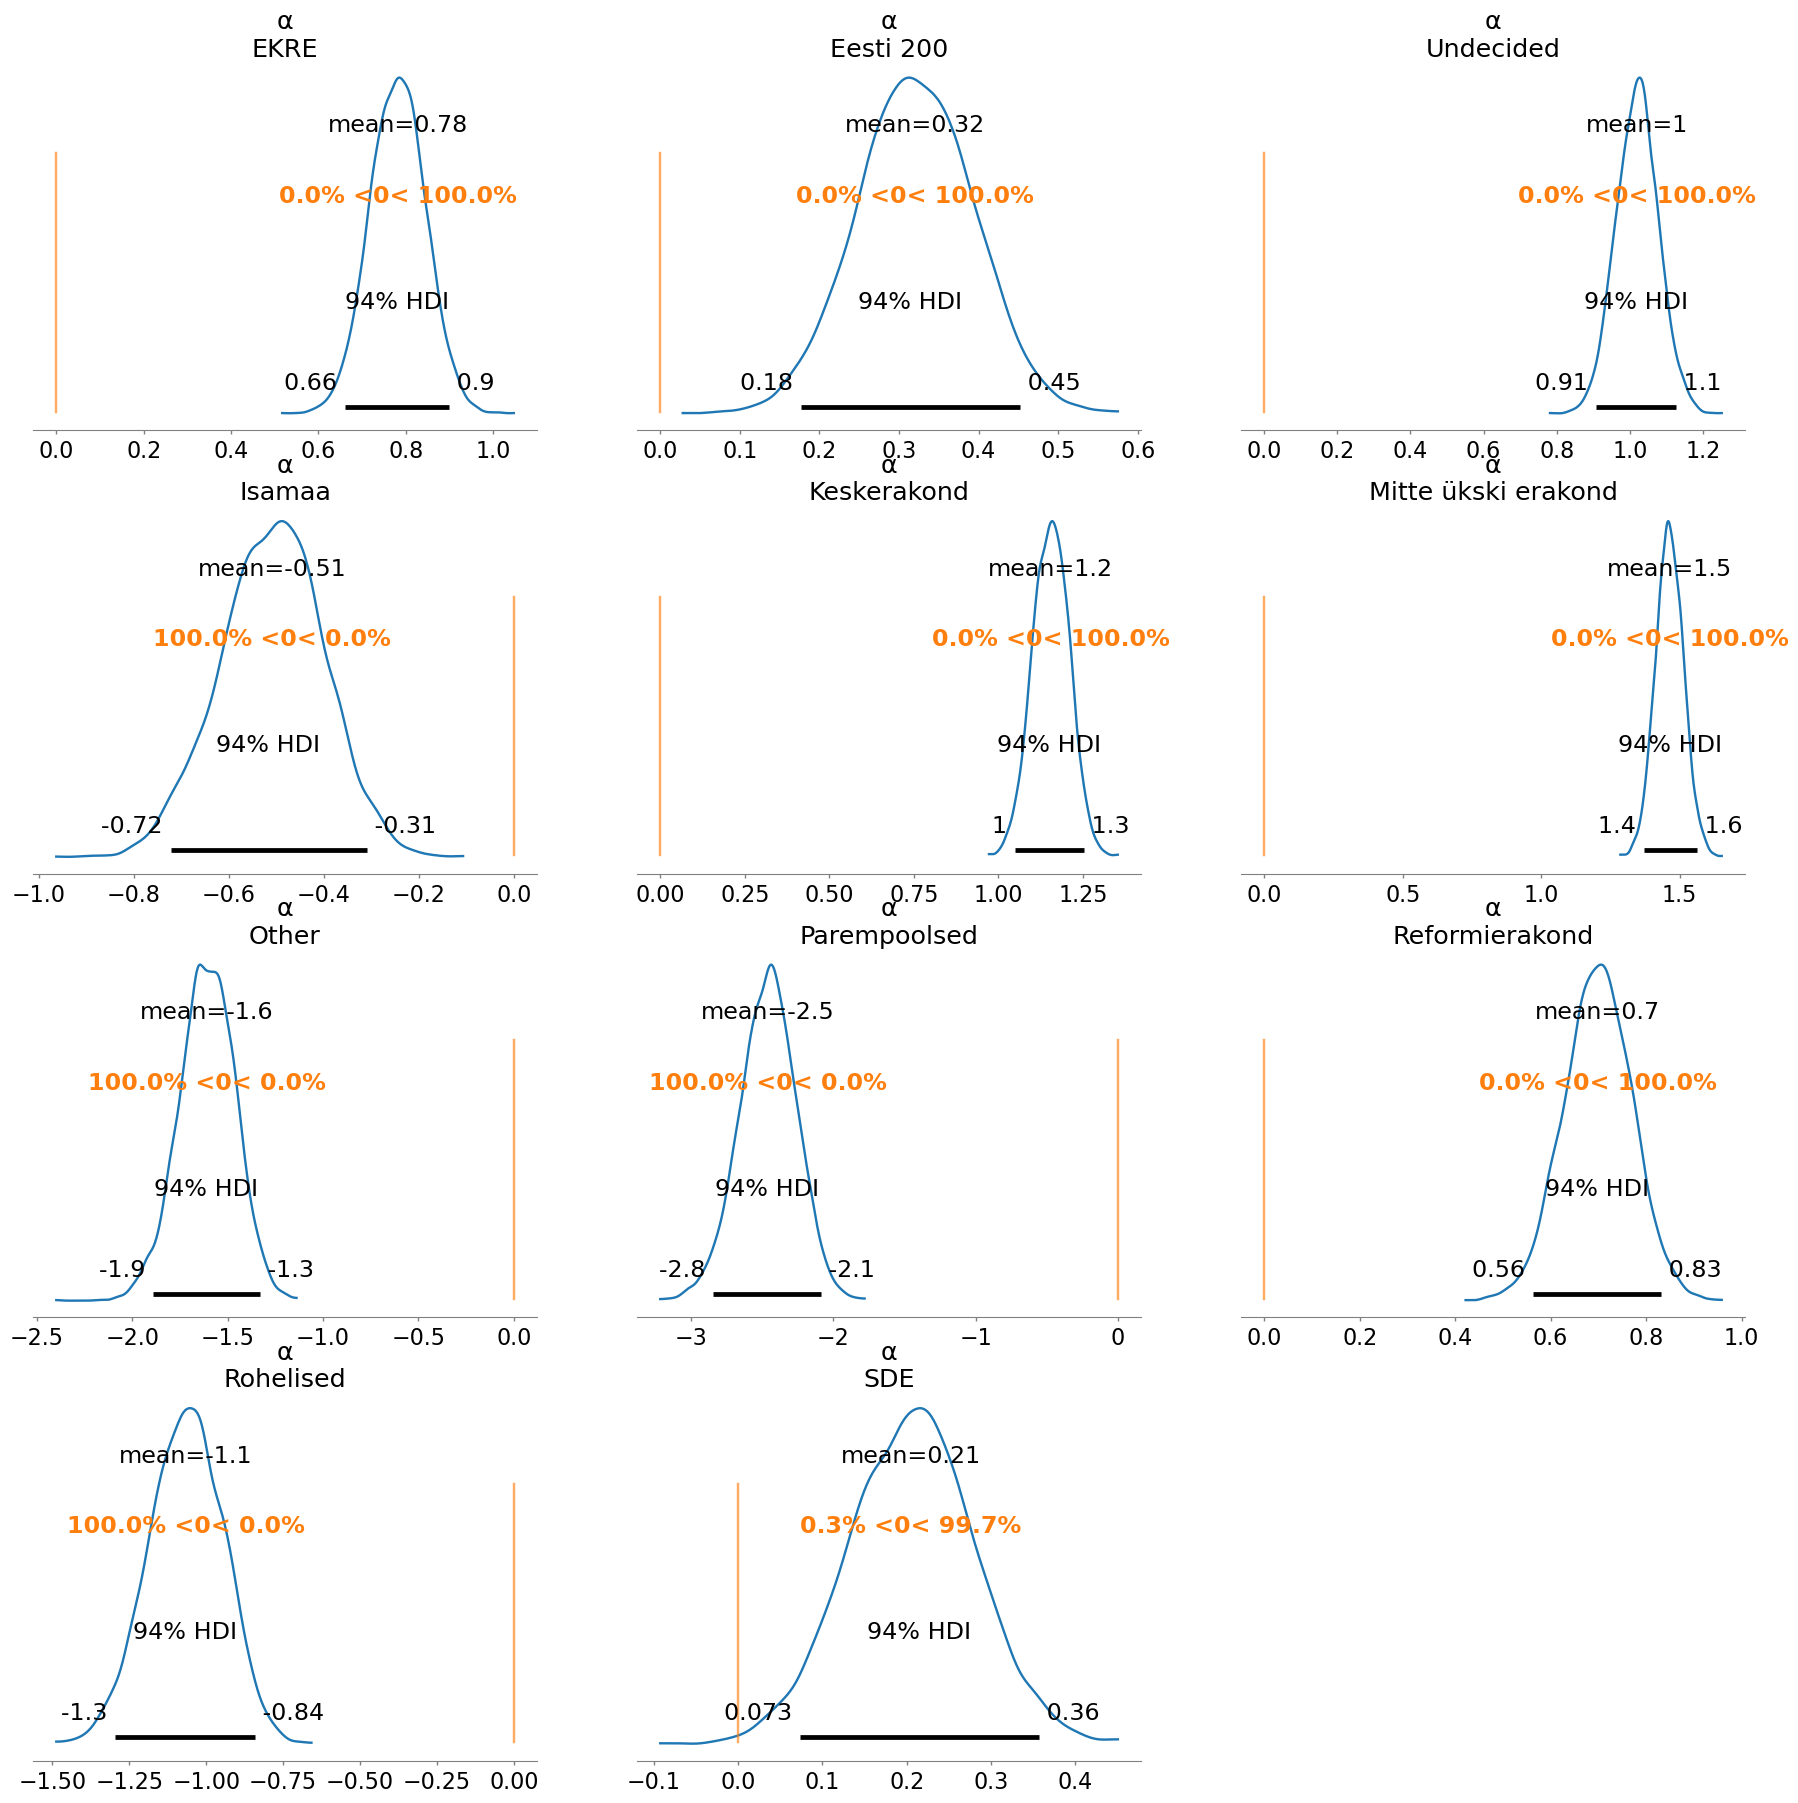

In [39]:
az.plot_posterior(idata1b, var_names='α', ref_val=0, textsize=16);


2. Education:
    * Basic Education: 
        * There is a very high probability that a voter belonging ot this category will be in favor of EKRE, Keskerakond, or Mitte
        * There is a very high probability against such a voter favoring Reformierakond, and to a lesser extent, SDE.
    * Secondary Education:
        * Voter have high probability of favoring EKRE and to a lesser extent Isamaa
        * Though not quite significant, voter are likely to be most hostile to SDE.
    * Higher Education:
        * Voters in this category are very hostile to EKRE, Mitte and Keskerakond and are unlikely to be undecided
        * Voters are quite sympathetic to Eesti and Reformierakond.



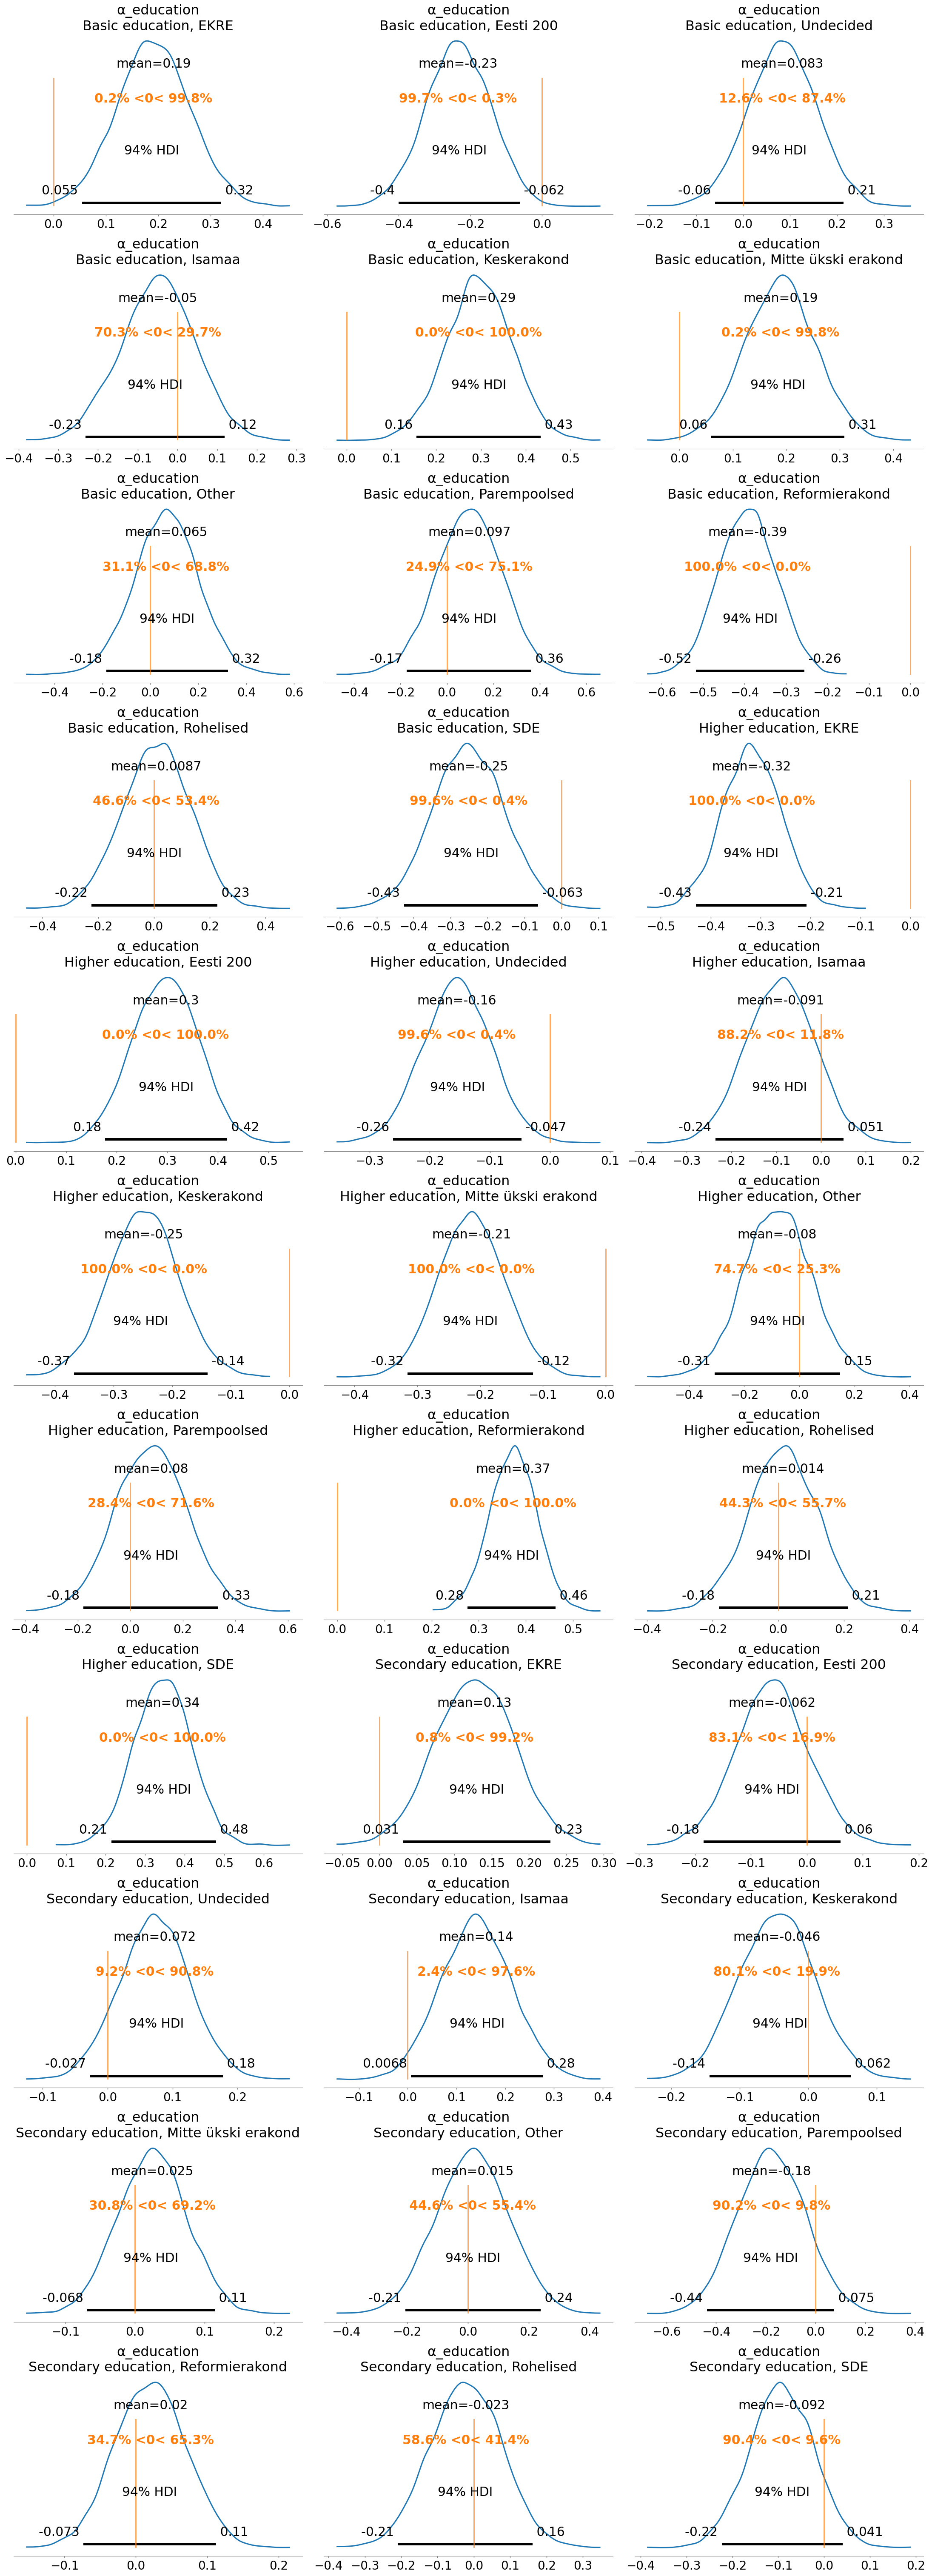

In [40]:
az.plot_posterior(idata1b, var_names='α_education', ref_val=0, backend_kwargs=dict(tight_layout=True), textsize=20);

3. Nationality
* Estonians are: 
    * predominantly favorable to EKRE, Isamaa, Reformierakond;
    * largely unfavorable to Keskerakond and Mitte, and are less likely to be Undecided.
* Ethnic Russians (Other) on the other hand:
    * favor Keskerakond, Mitte, and are more likely to be Undecided;
    * are hostile to Reformierakond and to a lesser extent EKRE.

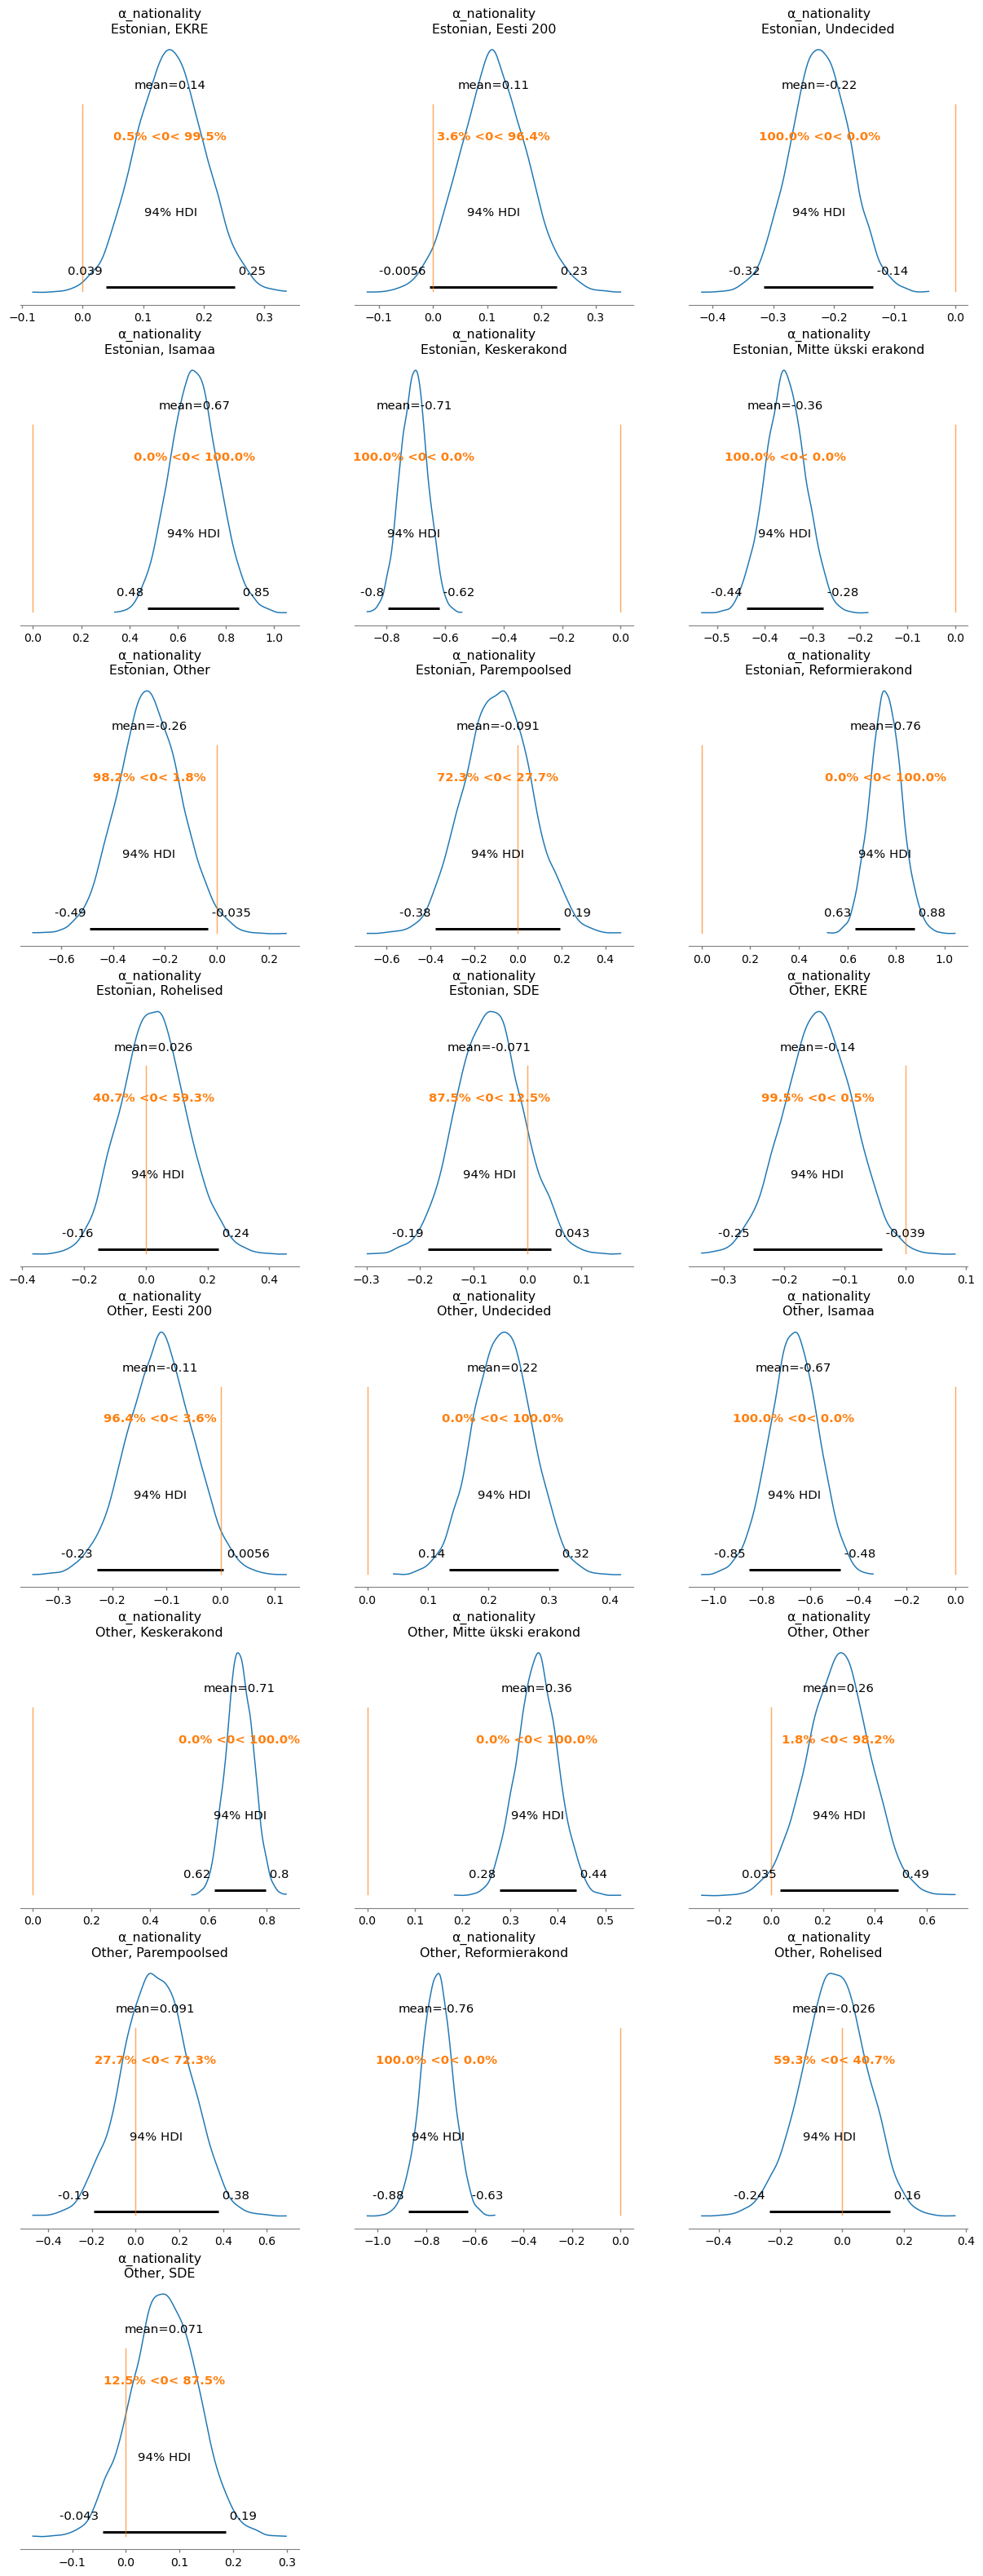

In [41]:
f, axs = pp.subplots(ncols=3, nrows=8, figsize=(15, 40))
for ax in axs.ravel()[-2:]:
    ax.set_visible(False)
az.plot_posterior(idata1b, var_names='α_nationality', backend_kwargs=dict(tight_layout=True), ref_val=0, ax=axs, textsize=10);
                

#### Adding gender and age group
In accordance with the Bayesian workflow, the next step is to build a slightly more complex model, in this case by adding gender and vote age group as predictors to nationality and education, and see if can extract further insight. The model type is the same, just with a total of 4 offsets to the baseline instead of 2. I will also use stronger informative priors as I did in the second model that I ended up using for my analysis. Finally, the prior distribution for all coefficients is again the ZeroSumNormal distribution that I use to avoid non-identifiability due to overparameterization.
But first, to encode the additional predictors...

In [42]:
gender_code, gender_label = data.gender.factorize(sort=True)
age_gp_code, age_group_label = data.age_group.factorize(sort=True)

In [43]:
coords = {
    'age group': age_group_label,
    'education': education_label,
    'gender': gender_label,
    'nationality': nationality_label,
    'party choice': party_choice_label,
    'obs_idx': data.index
}

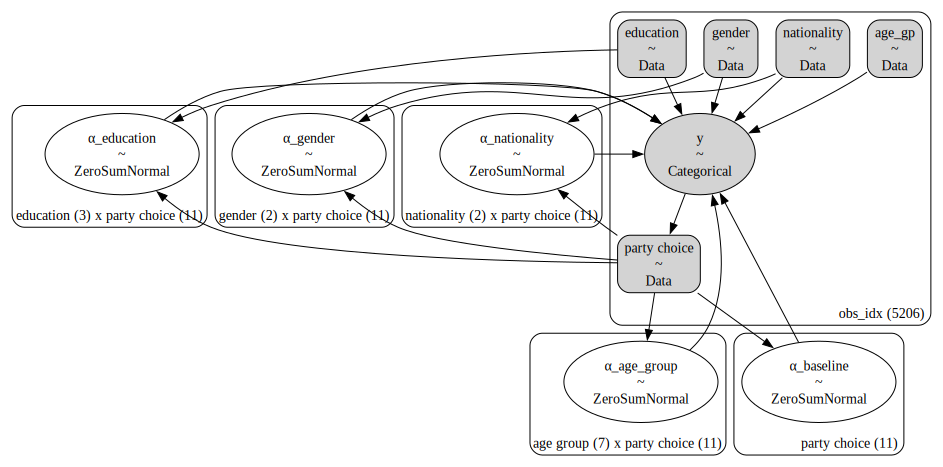

In [44]:
def build_model2(coords, σ_baseline=1, σ_age=1, σ_edu=1, σ_gen=1, σ_nat=1):
    with pm.Model(coords=coords) as model2:
        age_gp_idx = pm.Data('age_gp', age_gp_code, dims='obs_idx')
        educ_idx = pm.Data('education', education_code, dims='obs_idx')
        gender_idx = pm.Data('gender', gender_code, dims='obs_idx')
        nat_idx = pm.Data('nationality', nationality_code, dims='obs_idx')
        party_choice_idx = pm.Data('party choice', party_choice_code, dims='obs_idx') 
        
        α_baseline = pm.ZeroSumNormal('α_baseline', sigma=σ_baseline, dims='party choice')
        α_age_group = pm.ZeroSumNormal('α_age_group', sigma=σ_age, dims=('age group', 'party choice'), n_zerosum_axes=2)
        α_education = pm.ZeroSumNormal('α_education', sigma=σ_edu, dims=('education', 'party choice'), n_zerosum_axes=2)
        α_gender = pm.ZeroSumNormal('α_gender', sigma=σ_gen, dims=('gender', 'party choice'), n_zerosum_axes=2)
        α_nationality = pm.ZeroSumNormal('α_nationality', sigma=σ_nat, dims=('nationality', 'party choice'), n_zerosum_axes=2)

        μ = α_baseline + α_age_group[age_gp_idx] + α_education[educ_idx] + α_gender[gender_idx] + α_nationality[nat_idx]
        p = pm.math.softmax(μ, axis=-1)

        _ = pm.Categorical('y', p=p, observed=party_choice_idx, dims='obs_idx')
        
    return model2

model2 = build_model2(coords=coords, σ_baseline=0.3, σ_age=0.4, σ_edu=0.3, σ_gen=0.2, σ_nat=0.2)
model2.to_graphviz()

In [45]:
with model2:
    idata2 = pm.sample_prior_predictive()
    idata2.extend(pm.sample(chains=4, draws=2000, random_seed=42))
    idata2.extend(pm.sample_posterior_predictive(idata2))

Sampling: [y, α_age_group, α_baseline, α_education, α_gender, α_nationality]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_baseline, α_age_group, α_education, α_gender, α_nationality]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 140 seconds.
Sampling: [y, α_age_group, α_baseline, α_education, α_gender, α_nationality]


Output()

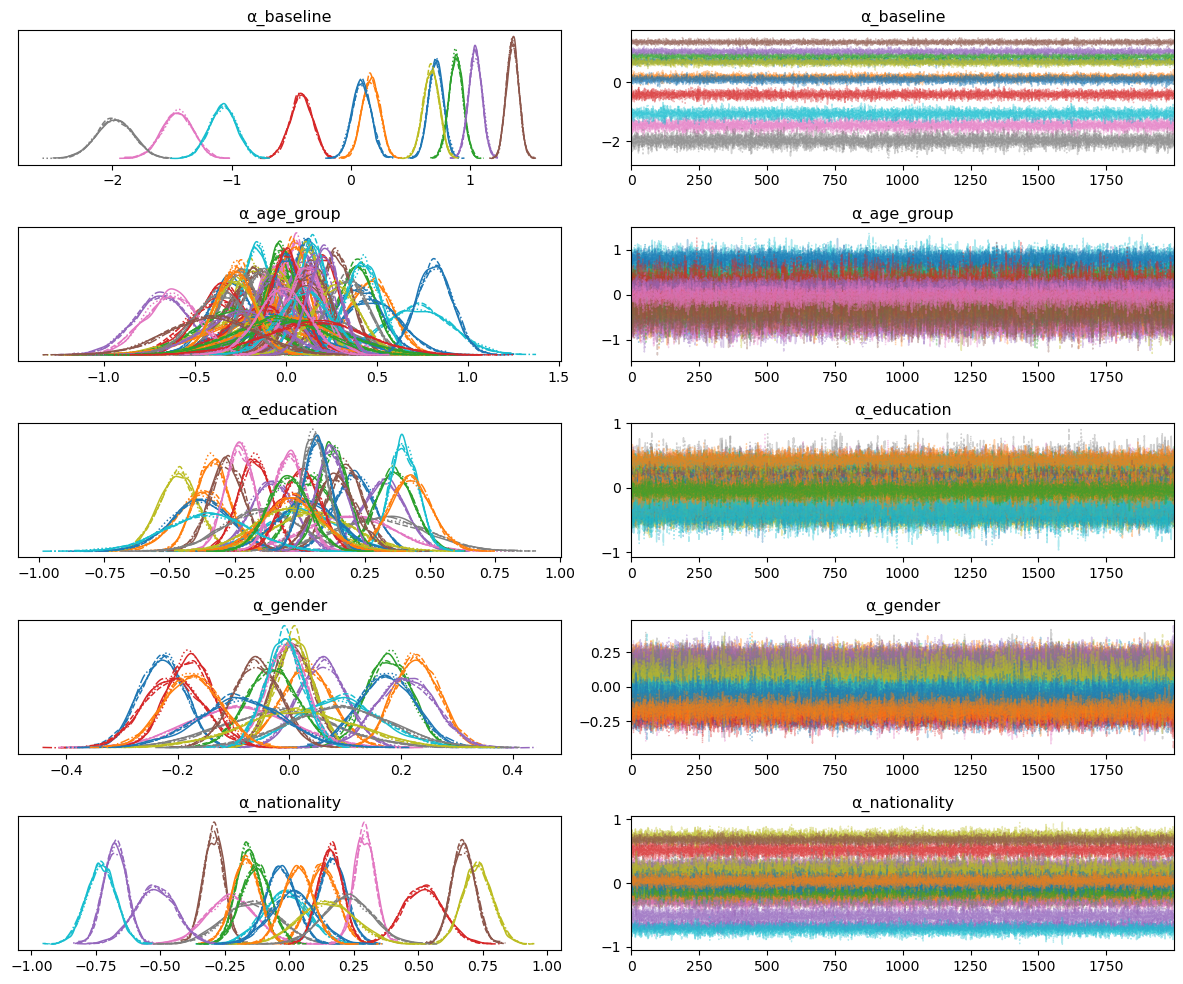

In [46]:
az.plot_trace(idata2, backend_kwargs=dict(tight_layout=True));

In [47]:
az.summary(idata2, var_names='α_baseline')

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
α_baseline[EKRE]                 0.713  0.061   0.598    0.826      0.001   
α_baseline[Eesti 200]            0.168  0.074   0.030    0.305      0.001   
α_baseline[Undecided]            0.882  0.059   0.772    0.995      0.001   
α_baseline[Isamaa]              -0.416  0.093  -0.586   -0.239      0.001   
α_baseline[Keskerakond]          1.044  0.056   0.944    1.157      0.000   
α_baseline[Mitte ükski erakond]  1.358  0.051   1.260    1.448      0.000   
α_baseline[Other]               -1.457  0.129  -1.695   -1.215      0.001   
α_baseline[Parempoolsed]        -1.982  0.151  -2.258   -1.695      0.001   
α_baseline[Reformierakond]       0.674  0.066   0.549    0.797      0.001   
α_baseline[Rohelised]           -1.073  0.113  -1.290   -0.866      0.001   
α_baseline[SDE]                  0.089  0.078  -0.052    0.237      0.001   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
α_baseline[EKRE]                   0.000   13176.0    6608.0    1.0  
α_baseline[Eesti 200]              0.000   12135.0    6429.0    1.0  
α_baseline[Undecided]              0.000   13437.0    6458.0    1.0  
α_baseline[Isamaa]                 0.001   13360.0    6345.0    1.0  
α_baseline[Keskerakond]            0.000   14123.0    6809.0    1.0  
α_baseline[Mitte ükski erakond]    0.000   12378.0    7131.0    1.0  
α_baseline[Other]                  0.001   13204.0    6783.0    1.0  
α_baseline[Parempoolsed]           0.001   14895.0    6244.0    1.0  
α_baseline[Reformierakond]         0.000   13091.0    6590.0    1.0  
α_baseline[Rohelised]              0.001   13350.0    6760.0    1.0  
α_baseline[SDE]                    0.001   11862.0    6514.0    1.0

In [50]:
az.summary(idata2, var_names='α_age_group')

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
α_age_group[16-24, EKRE]         -0.307  0.122  -0.537   -0.080      0.001   
α_age_group[16-24, Eesti 200]     0.465  0.121   0.240    0.696      0.001   
α_age_group[16-24, Undecided]     0.011  0.114  -0.205    0.225      0.001   
α_age_group[16-24, Isamaa]       -0.379  0.167  -0.684   -0.070      0.001   
α_age_group[16-24, Keskerakond]  -0.685  0.150  -0.959   -0.400      0.001   
...                                 ...    ...     ...      ...        ...   
α_age_group[75+, Other]          -0.044  0.252  -0.509    0.438      0.002   
α_age_group[75+, Parempoolsed]    0.156  0.279  -0.350    0.715      0.002   
α_age_group[75+, Reformierakond]  0.209  0.087   0.052    0.378      0.001   
α_age_group[75+, Rohelised]      -0.412  0.234  -0.838    0.033      0.002   
α_age_group[75+, SDE]            -0.017  0.138  -0.287    0.228      0.001   

                                  mcse_sd  ess_bulk  ess_tail  r_hat  
α_age_group[16-24, EKRE]            0.001   16900.0    5979.0    1.0  
α_age_group[16-24, Eesti 200]       0.001   16699.0    6892.0    1.0  
α_age_group[16-24, Undecided]       0.001   14880.0    5789.0    1.0  
α_age_group[16-24, Isamaa]          0.001   17991.0    5771.0    1.0  
α_age_group[16-24, Keskerakond]     0.001   17828.0    5346.0    1.0  
...                                   ...       ...       ...    ...  
α_age_group[75+, Other]             0.003   16116.0    5912.0    1.0  
α_age_group[75+, Parempoolsed]      0.003   17245.0    6678.0    1.0  
α_age_group[75+, Reformierakond]    0.001   14009.0    6339.0    1.0  
α_age_group[75+, Rohelised]         0.002   14955.0    6332.0    1.0  
α_age_group[75+, SDE]               0.002   14714.0    5968.0    1.0  

[77 rows x 9 columns]

In [51]:
az.summary(idata2, var_names='α_education')

mean     sd  hdi_3%  \
α_education[Basic education, EKRE]                  0.208  0.076   0.068   
α_education[Basic education, Eesti 200]            -0.371  0.102  -0.553   
α_education[Basic education, Undecided]             0.053  0.080  -0.096   
α_education[Basic education, Isamaa]               -0.031  0.107  -0.235   
α_education[Basic education, Keskerakond]           0.321  0.084   0.165   
α_education[Basic education, Mitte ükski erakond]   0.175  0.069   0.044   
α_education[Basic education, Other]                 0.187  0.166  -0.128   
α_education[Basic education, Parempoolsed]          0.304  0.177  -0.022   
α_education[Basic education, Reformierakond]       -0.466  0.077  -0.623   
α_education[Basic education, Rohelised]             0.001  0.143  -0.281   
α_education[Basic education, SDE]                  -0.381  0.115  -0.588   
α_education[Higher education, EKRE]                -0.336  0.064  -0.453   
α_education[Higher education, Eesti 200]            0.365  0.073   0.230   
α_education[Higher education, Undecided]           -0.173  0.063  -0.291   
α_education[Higher education, Isamaa]              -0.104  0.084  -0.255   
α_education[Higher education, Keskerakond]         -0.280  0.066  -0.407   
α_education[Higher education, Mitte ükski erakond] -0.231  0.056  -0.339   
α_education[Higher education, Other]               -0.145  0.143  -0.417   
α_education[Higher education, Parempoolsed]         0.050  0.157  -0.249   
α_education[Higher education, Reformierakond]       0.400  0.055   0.302   
α_education[Higher education, Rohelised]            0.029  0.119  -0.198   
α_education[Higher education, SDE]                  0.425  0.081   0.272   
α_education[Secondary education, EKRE]              0.128  0.057   0.027   
α_education[Secondary education, Eesti 200]         0.006  0.072  -0.125   
α_education[Secondary education, Undecided]         0.121  0.058   0.010   
α_education[Secondary education, Isamaa]            0.135  0.080  -0.013   
α_education[Secondary education, Keskerakond]      -0.041  0.060  -0.155   
α_education[Secondary education, Mitte ükski er...  0.056  0.051  -0.039   
α_education[Secondary education, Other]            -0.042  0.135  -0.291   
α_education[Secondary education, Parempoolsed]     -0.355  0.159  -0.647   
α_education[Secondary education, Reformierakond]    0.067  0.053  -0.036   
α_education[Secondary education, Rohelised]        -0.030  0.110  -0.240   
α_education[Secondary education, SDE]              -0.044  0.079  -0.185   

                                                    hdi_97%  mcse_mean  \
α_education[Basic education, EKRE]                    0.353      0.001   
α_education[Basic education, Eesti 200]              -0.172      0.001   
α_education[Basic education, Undecided]               0.203      0.001   
α_education[Basic education, Isamaa]                  0.164      0.001   
α_education[Basic education, Keskerakond]             0.476      0.001   
α_education[Basic education, Mitte ükski erakond]     0.305      0.001   
α_education[Basic education, Other]                   0.491      0.001   
α_education[Basic education, Parempoolsed]            0.640      0.001   
α_education[Basic education, Reformierakond]         -0.336      0.001   
α_education[Basic education, Rohelised]               0.261      0.001   
α_education[Basic education, SDE]                    -0.158      0.001   
α_education[Higher education, EKRE]                  -0.214      0.000   
α_education[Higher education, Eesti 200]              0.508      0.001   
α_education[Higher education, Undecided]             -0.055      0.001   
α_education[Higher education, Isamaa]                 0.054      0.001   
α_education[Higher education, Keskerakond]           -0.161      0.001   
α_education[Higher education, Mitte ükski erakond]   -0.129      0.000   
α_education[Higher education, Other]                  0.121      0.001   
α_education[Higher education, Parempoolsed]           0.353   

In [52]:
az.summary(idata2, var_names='α_gender')

mean     sd  hdi_3%  hdi_97%  \
α_gender[Female, EKRE]                -0.228  0.041  -0.308   -0.157   
α_gender[Female, Eesti 200]            0.031  0.047  -0.057    0.118   
α_gender[Female, Undecided]            0.178  0.041   0.101    0.253   
α_gender[Female, Isamaa]              -0.209  0.053  -0.306   -0.110   
α_gender[Female, Keskerakond]          0.059  0.043  -0.023    0.139   
α_gender[Female, Mitte ükski erakond]  0.005  0.036  -0.062    0.072   
α_gender[Female, Other]               -0.089  0.092  -0.259    0.088   
α_gender[Female, Parempoolsed]        -0.018  0.101  -0.206    0.175   
α_gender[Female, Reformierakond]       0.009  0.035  -0.056    0.074   
α_gender[Female, Rohelised]            0.087  0.078  -0.056    0.237   
α_gender[Female, SDE]                  0.174  0.050   0.082    0.270   
α_gender[Male, EKRE]                   0.228  0.041   0.157    0.308   
α_gender[Male, Eesti 200]             -0.031  0.047  -0.118    0.057   
α_gender[Male, Undecided]             -0.178  0.041  -0.253   -0.101   
α_gender[Male, Isamaa]                 0.209  0.053   0.110    0.306   
α_gender[Male, Keskerakond]           -0.059  0.043  -0.139    0.023   
α_gender[Male, Mitte ükski erakond]   -0.005  0.036  -0.072    0.062   
α_gender[Male, Other]                  0.089  0.092  -0.088    0.259   
α_gender[Male, Parempoolsed]           0.018  0.101  -0.175    0.206   
α_gender[Male, Reformierakond]        -0.009  0.035  -0.074    0.056   
α_gender[Male, Rohelised]             -0.087  0.078  -0.237    0.056   
α_gender[Male, SDE]                   -0.174  0.050  -0.270   -0.082   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α_gender[Female, EKRE]                     0.000    0.000   17338.0    6441.0   
α_gender[Female, Eesti 200]                0.000    0.000   16743.0    6071.0   
α_gender[Female, Undecided]                0.000    0.000   15502.0    6196.0   
α_gender[Female, Isamaa]                   0.000    0.000   18282.0    5863.0   
α_gender[Female, Keskerakond]              0.000    0.000   17925.0    6789.0   
α_gender[Female, Mitte ükski erakond]      0.000    0.000   13068.0    5882.0   
α_gender[Female, Other]                    0.001    0.001   15853.0    5529.0   
α_gender[Female, Parempoolsed]             0.001    0.001   17983.0    6359.0   
α_gender[Female, Reformierakond]           0.000    0.000   14718.0    6247.0   
α_gender[Female, Rohelised]                0.001    0.001   17240.0    6054.0   
α_gender[Female, SDE]                      0.000    0.000   12087.0    6810.0   
α_gender[Male, EKRE]                       0.000    0.000   17338.0    6441.0   
α_gender[Male, Eesti 200]                  0.000    0.000   16743.0    6071.0   
α_gender[Male, Undecided]                  0.000    0.000   15502.0    6196.0   
α_gender[Male, Isamaa]                     0.000    0.000   18282.0    5863.0   
α_gender[Male, Keskerakond]                0.000    0.000   17925.0    6789.0   
α_gender[Male, Mitte ükski erakond]        0.000    0.000   13068.0    5882.0   
α_gender[Male, Other]                      0.001    0.001   15853.0    5529.0   
α_gender[Male, Parempoolsed]               0.001    0.001   17983.0    6359.0   
α_gender[Male, Reformierakond]             0.000    0.000   14718.0    6247.0   
α_gender[Male, Rohelised]                  0.001    0.001   17240.0    6054.0   
α_gender[Male, SDE]                        0.000    0.000   12087.0    6810.0   

                                       r_hat  
α_gender[Female, EKRE]                   1.0  
α_gender[Female, Eesti 200]              1.0  
α_gender[Female, Undecided]              1.0  
α_gender[Female, Isamaa]                 1.0  
α_gender[Female, Keskerakond]            1.0  
α_gender[Female, Mitte ükski erakond]    1.0  
α_gender[Female, Other]                  1.0  
α_gender[Female, Parempoolsed]           1.0  
α_gender[Female, Reformierakond]         1.0  
α_gender[Female, Rohelised]              1.0  
α_

In [53]:
az.summary(idata2, var_names='α_nationality')

mean     sd  hdi_3%  hdi_97%  \
α_nationality[Estonian, EKRE]                 0.169  0.053   0.073    0.271   
α_nationality[Estonian, Eesti 200]            0.130  0.057   0.018    0.233   
α_nationality[Estonian, Undecided]           -0.159  0.046  -0.244   -0.072   
α_nationality[Estonian, Isamaa]               0.518  0.079   0.366    0.660   
α_nationality[Estonian, Keskerakond]         -0.675  0.045  -0.756   -0.590   
α_nationality[Estonian, Mitte ükski erakond] -0.294  0.040  -0.373   -0.222   
α_nationality[Estonian, Other]               -0.225  0.095  -0.400   -0.044   
α_nationality[Estonian, Parempoolsed]        -0.145  0.106  -0.340    0.052   
α_nationality[Estonian, Reformierakond]       0.730  0.057   0.625    0.837   
α_nationality[Estonian, Rohelised]           -0.015  0.088  -0.183    0.145   
α_nationality[Estonian, SDE]                 -0.033  0.058  -0.140    0.080   
α_nationality[Other, EKRE]                   -0.169  0.053  -0.271   -0.073   
α_nationality[Other, Eesti 200]              -0.130  0.057  -0.233   -0.018   
α_nationality[Other, Undecided]               0.159  0.046   0.072    0.244   
α_nationality[Other, Isamaa]                 -0.518  0.079  -0.660   -0.366   
α_nationality[Other, Keskerakond]             0.675  0.045   0.590    0.756   
α_nationality[Other, Mitte ükski erakond]     0.294  0.040   0.222    0.373   
α_nationality[Other, Other]                   0.225  0.095   0.044    0.400   
α_nationality[Other, Parempoolsed]            0.145  0.106  -0.052    0.340   
α_nationality[Other, Reformierakond]         -0.730  0.057  -0.837   -0.625   
α_nationality[Other, Rohelised]               0.015  0.088  -0.145    0.183   
α_nationality[Other, SDE]                     0.033  0.058  -0.080    0.140   

                                              mcse_mean  mcse_sd  ess_bulk  \
α_nationality[Estonian, EKRE]                     0.000    0.000   14414.0   
α_nationality[Estonian, Eesti 200]                0.000    0.000   15715.0   
α_nationality[Estonian, Undecided]                0.000    0.000   14413.0   
α_nationality[Estonian, Isamaa]                   0.001    0.000   13569.0   
α_nationality[Estonian, Keskerakond]              0.000    0.000   14815.0   
α_nationality[Estonian, Mitte ükski erakond]      0.000    0.000   13450.0   
α_nationality[Estonian, Other]                    0.001    0.001   16229.0   
α_nationality[Estonian, Parempoolsed]             0.001    0.001   15378.0   
α_nationality[Estonian, Reformierakond]           0.000    0.000   13500.0   
α_nationality[Estonian, Rohelised]                0.001    0.001   14598.0   
α_nationality[Estonian, SDE]                      0.001    0.001   11830.0   
α_nationality[Other, EKRE]                        0.000    0.000   14414.0   
α_nationality[Other, Eesti 200]                   0.000    0.000   15715.0   
α_nationality[Other, Undecided]                   0.000    0.000   14413.0   
α_nationality[Other, Isamaa]                      0.001    0.000   13569.0   
α_nationality[Other, Keskerakond]                 0.000    0.000   14815.0   
α_nationality[Other, Mitte ükski erakond]         0.000    0.000   13450.0   
α_nationality[Other, Other]                       0.001    0.001   16229.0   
α_nationality[Other, Parempoolsed]                0.001    0.001   15378.0   
α_nationality[Other, Reformierakond]              0.000    0.000   13500.0   
α_nationality[Other, Rohelised]                   0.001    0.001   14598.0   
α_nationality[Other, SDE]                         0.001    0.001   11830.0   

                                              ess_tail  r_hat  
α_nationality[Estonian, EKRE]                   6430.0    1.0  
α_nationality[Estonian, Eesti 200]              7377.0    1.0  
α_nationality[Estonian, Undecided]              7107.0    1.0  
α_nationality[Estonian, Isamaa]                 6383.0    1.0  
α_nationality[Estonian, Keskerakond]            6751.0    1.0  
α_nationality[Estonian, Mitte ükski erakond]    66

The fit took predictably longer; 2 minutes and 20 seconds on my macbook air m2. Moreover, 
* There were no divergences;
* Posteriors look sound and the traces exhibit good mixing for all chains;
* All $\hat{R}$ values were 1
* Bulk and tail ESS are about the same as the model with two predictors and relatively informative priors suggesting sampling efficiency has not deteriorated as a result of the increased model complexity.